In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [103]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda, Reshape, LeakyReLU, Attention


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## FFT + Dense Layer out

In [39]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Frequency Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2, 1])(timeDist) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist.shape',timeDist.shape)
fftLayer = Lambda(lambda x : tf.math.abs(tf.signal.rfft(x)))(timeDist) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1], name="fft_out")(fftLayer)#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(100))(fftLayer)
units = timeDist4.shape[2]

Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(timeDist4)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense_out2))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_FFT")
model.summary()

adam = optimizers.Adam(lr)
#rmsProp = optimizers.RMSprop(learning_rate=lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


timeDist.shape (None, 10000, 52)
fftLayer.shape (None, 27, 10000)
Model: "Attention_FFT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 52, 10000)         0         
_________________________________________________________________
permute_2 (Permute)          (None, 10000, 52)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 10000, 27)         0         
_________________________________________________________________
fft_out (Permute)            (None, 27, 10000)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 27, 100)           1000100   
_____________________________________________________

#### FFT + Attention vs FFT + Dense layer out have identical MAE. This proves attention is not needed for frequency domain data.

## TimeDistributed attention + attention on time

In [131]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
units = 1000
timeDist = TimeDistributed(Dense(units))(timeDist)
print("timeDist", timeDist.shape)
#timeDist = Reshape((attentionTD.shape[1],attentionTD.shape[2],1))(timeDist)
#print("timeDist reshaped: ", attentionTD.shape)

attentionTD = TimeDistributed(Dense(units, activation='tanh'))(timeDist) ## weight matrix W (= units x units)
attentionTD = TimeDistributed(Dense(1, activation='linear'))(attentionTD)     ## weight matrix v (= units x 1)
attentionTD = TimeDistributed(Flatten())(attentionTD)
attentionTD = TimeDistributed(Activation('softmax',name='attentionTD_weights'))(attentionTD)
print(attentionTD.shape)
attentionTD = TimeDistributed(RepeatVector(units))(attentionTD)
print(attentionTD.shape)
attentionTD = TimeDistributed(Permute([2, 1]))(attentionTD)
print("attention: ", attentionTD.shape)

attentionTD = Lambda(lambda X: tf.math.multiply(X[0],X[1]))([timeDist, attentionTD])
print("result:", attentionTD.shape)
timeDist2 = TimeDistributed(Dense(100))(timeDist)
units = timeDist2.shape[2]

# compute importance for each step
attention = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
attention = Flatten()(attention)
attention = Activation('softmax',name='attention_weights')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2

model = Model(inputs, outputs, name="TimeDistributed_Attention_plus_Attention_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


timeDist (None, 52, 1000)
(None, 52, 1)
(None, 52, 1000, 1)
attention:  (None, 52, 1, 1000)
result: (None, 52, 52, 1000)
Model: "TimeDistributed_Attention_plus_Attention_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_408 (TimeDistr (None, 52, 10000)    0           input_51[0][0]                   
__________________________________________________________________________________________________
time_distributed_409 (TimeDistr (None, 52, 1000)     10001000    time_distributed_408[0][0]       
__________________________________________________________________________________________________
time_distributed_416 (TimeDis

In [132]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

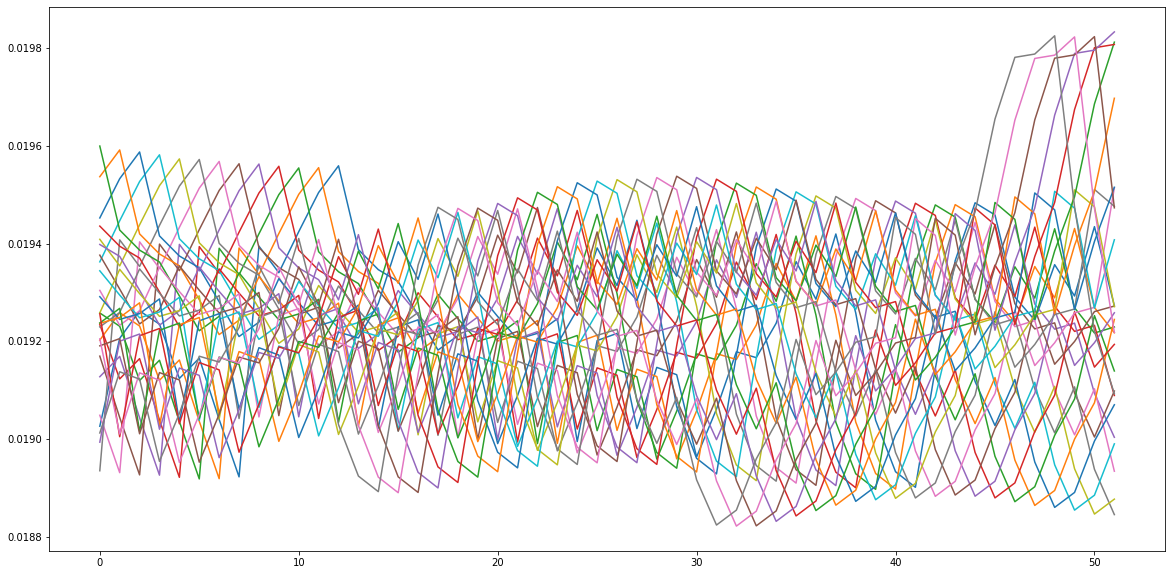

In [133]:
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

#### Each head converged to similar pattern to previous independent time and frequency domain mode.

## Run fit on any of the previous model here

In [ ]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=6, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "TimeDistributed_Attention_plus_Attention_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_408 (TimeDistr (None, 52, 10000)    0           input_51[0][0]                   
__________________________________________________________________________________________________
time_distributed_409 (TimeDistr (None, 52, 1000)     10001000    time_distributed_408[0][0]       
__________________________________________________________________________________________________
time_distributed_416 (TimeDistr (None, 52, 100)      100100      time_distributed_409[0][0]       
___________________________________________________

88/88 [==============================] - 0s 5ms/sample - loss: 0.0053 - mae: 0.0053 - val_loss: 0.0053 - val_mae: 0.0053
Epoch 12/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0052 - mae: 0.0052
Epoch 00012: val_loss improved from 0.00528 to 0.00510, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0051 - mae: 0.0051 - val_loss: 0.0051 - val_mae: 0.0051
Epoch 13/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0050 - mae: 0.0050
Epoch 00013: val_loss improved from 0.00510 to 0.00492, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0049 - mae: 0.0049 - val_loss: 0.0049 - val_mae: 0.0049
Epo

88/88 [==============================] - 0s 4ms/sample - loss: 0.0030 - mae: 0.0030 - val_loss: 0.0031 - val_mae: 0.0031
Epoch 31/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0030 - mae: 0.0030
Epoch 00031: val_loss improved from 0.00308 to 0.00302, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0030 - mae: 0.0030 - val_loss: 0.0030 - val_mae: 0.0030
Epoch 32/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0029 - mae: 0.0029
Epoch 00032: val_loss improved from 0.00302 to 0.00295, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0029 - mae: 0.0029 - val_loss: 0.0030 - val_mae: 0.0030
Epo

88/88 [==============================] - 0s 4ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 50/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0022
Epoch 00050: val_loss improved from 0.00233 to 0.00230, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 51/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0022 - mae: 0.0022
Epoch 00051: val_loss improved from 0.00230 to 0.00228, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 5ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epo

88/88 [==============================] - 0s 4ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 69/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00069: val_loss improved from 0.00206 to 0.00204, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 5ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0020 - val_mae: 0.0020
Epoch 70/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00070: val_loss improved from 0.00204 to 0.00204, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 5ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0020 - val_mae: 0.0020
Epo

88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 89/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00089: val_loss improved from 0.00192 to 0.00192, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 90/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00090: val_loss improved from 0.00192 to 0.00192, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 5ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epo

Epoch 109/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00109: val_loss did not improve from 0.00186
88/88 [==============================] - 0s 3ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 110/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00110: val_loss improved from 0.00186 to 0.00186, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 111/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00111: val_loss did not improve from 0.00186
88/88 [==============================] - 0s 3ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 112/1000
60/88 [=========

88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 133/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00133: val_loss did not improve from 0.00182
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 134/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00134: val_loss improved from 0.00182 to 0.00181, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 5ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 135/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00135: val_loss improved from 0.00181 to 0.00181, saving model to /home/zhim

60/88 [===================>..........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00156: val_loss did not improve from 0.00179
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 157/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00157: val_loss did not improve from 0.00179
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 158/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00158: val_loss improved from 0.00179 to 0.00179, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 5ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 159/1000
66/88 [=====================>..

84/88 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00183: val_loss improved from 0.00176 to 0.00176, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 5ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 184/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00184: val_loss did not improve from 0.00176
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 185/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00185: val_loss did not improve from 0.00176
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 186/1000
84/88 [========================

Epoch 209/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00209: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 210/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00210: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 211/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00211: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 212/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00212: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss

Epoch 237/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00237: val_loss improved from 0.00174 to 0.00174, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200706-221854_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 238/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00238: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 239/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00239: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 240/1000
66/88 [=========

Epoch 265/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00265: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 266/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00266: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 267/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00267: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 268/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00268: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss

#### Test Set accuracy

#### Flattened+Attention

In [54]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002142413, valid_loss=0.002142413053661585


#### Flattened+LSTM+Attention

In [48]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021439143, valid_loss=0.002143914345651865


#### FFT+Attention

In [104]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002143551, valid_loss=0.0021435508970171213


#### Adam Optimize:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016915

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016920

### Best FFT + Attention Heads on  TimeDistributed is at MAE of 0.0016920

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [45]:
Predict = model.predict(X_valid)

In [46]:
Predict.shape

(28, 10000)

In [47]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [48]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

In [59]:
Y_valid.shape

(28, 10000)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


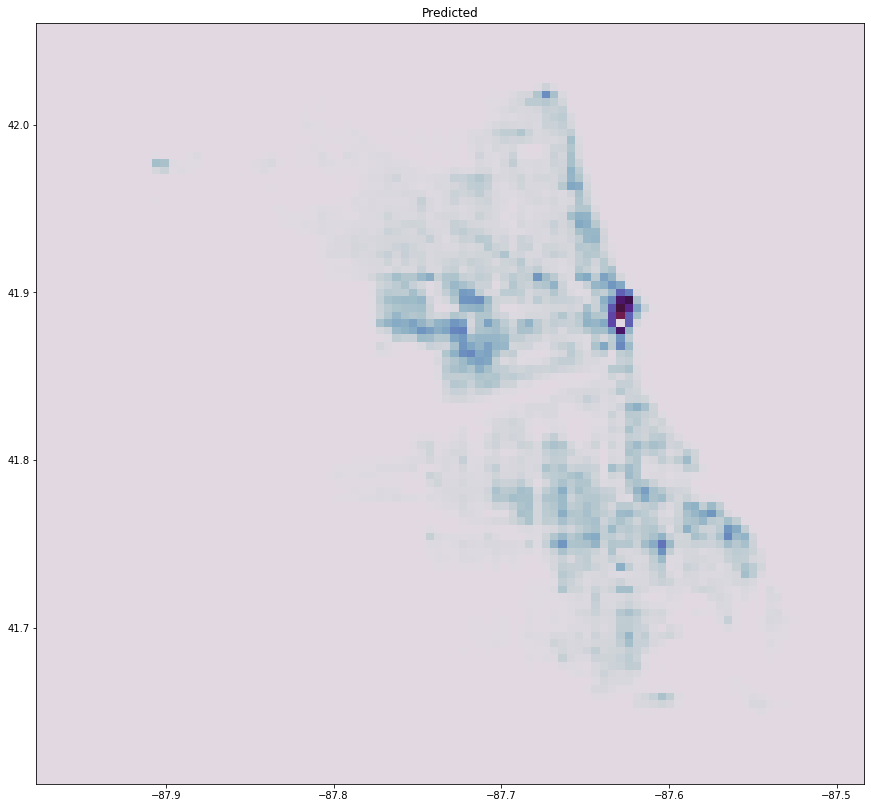

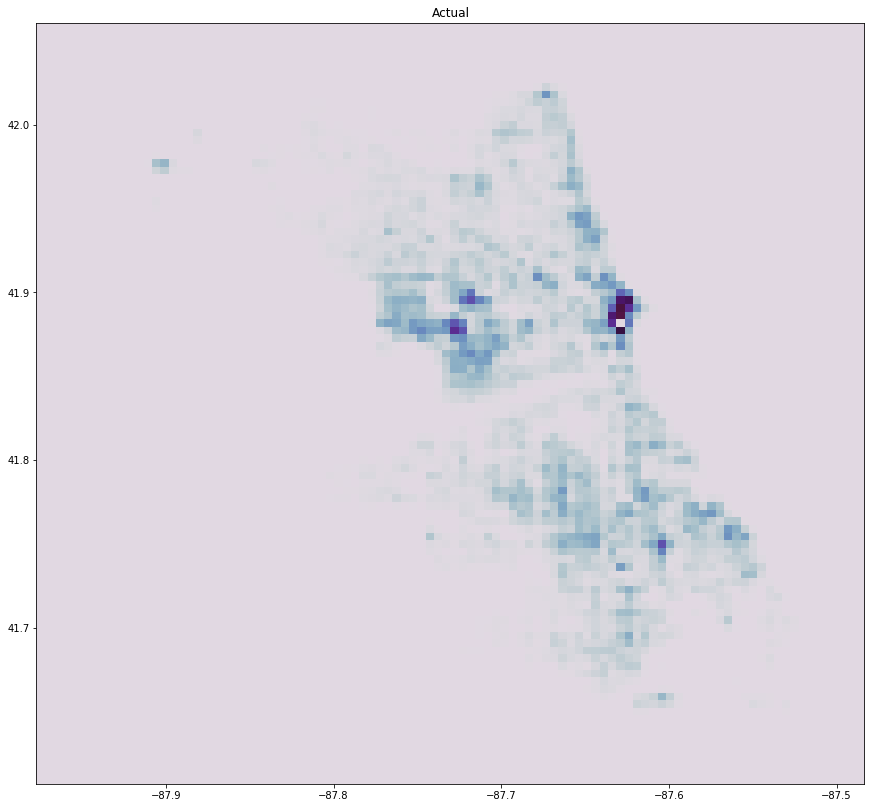

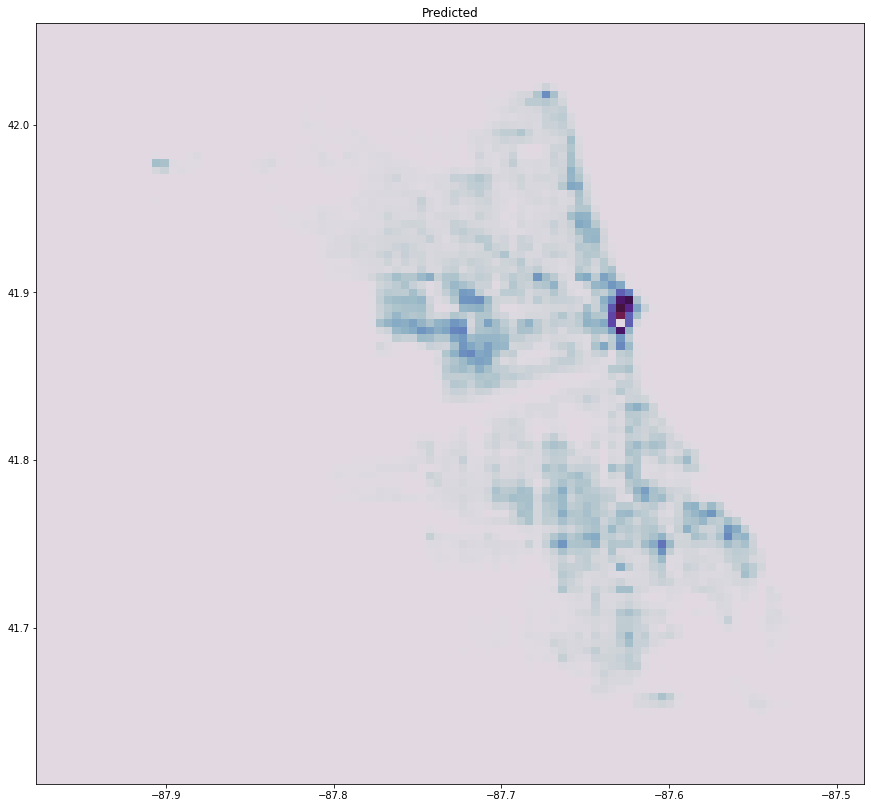

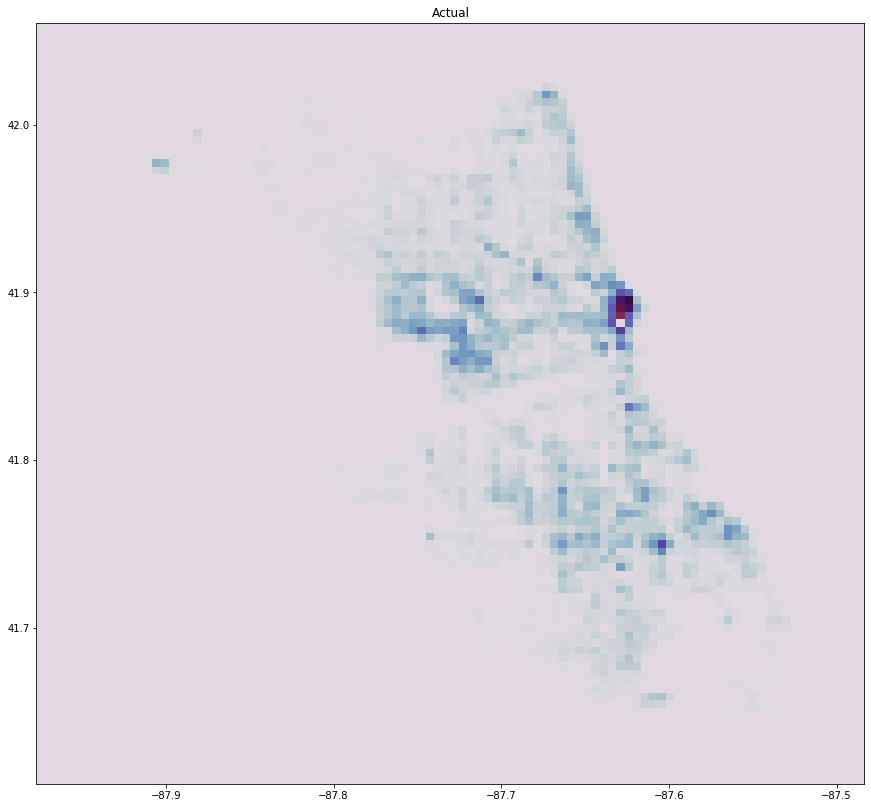

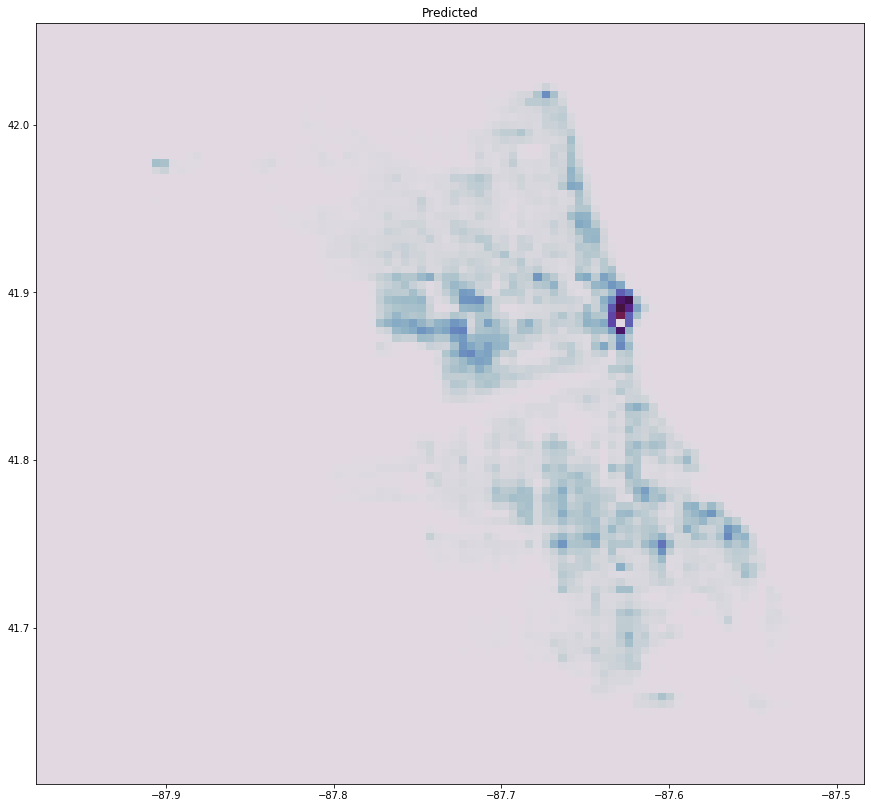

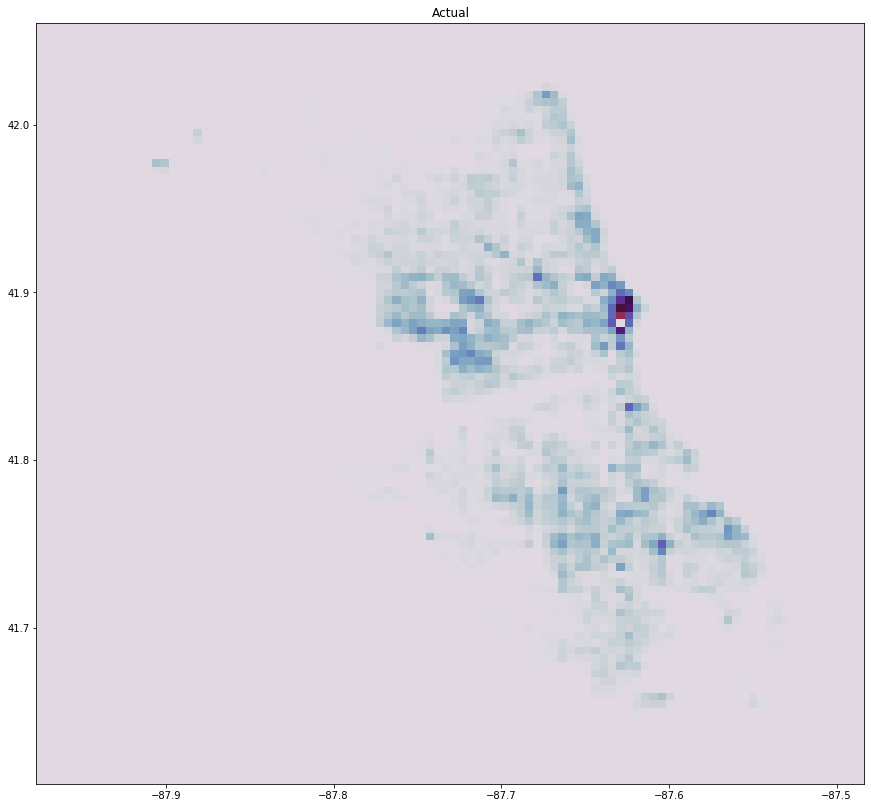

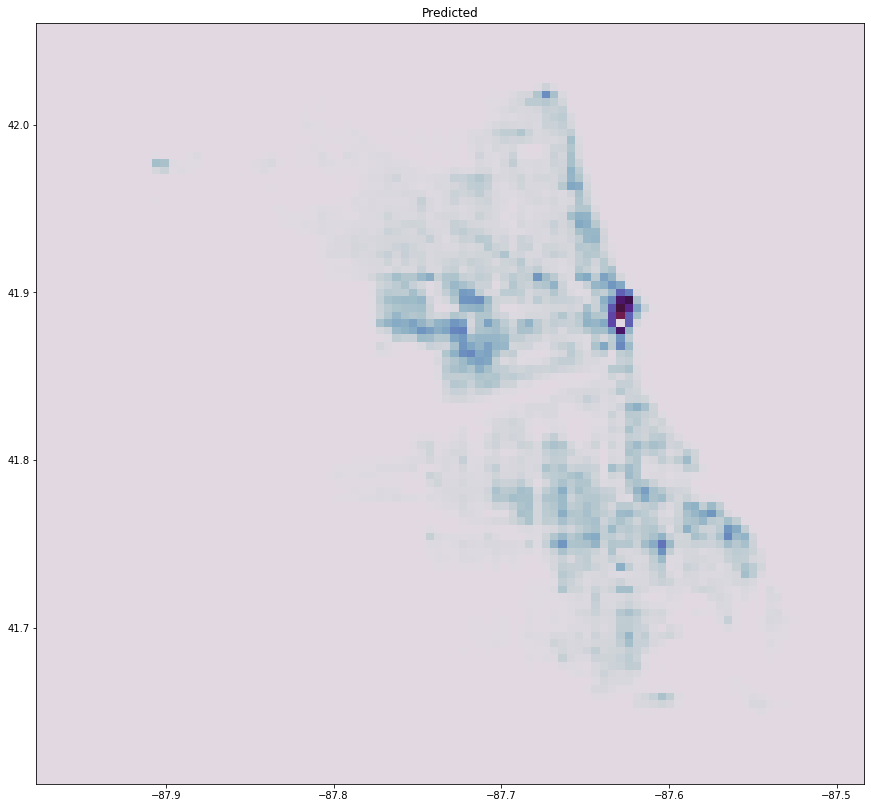

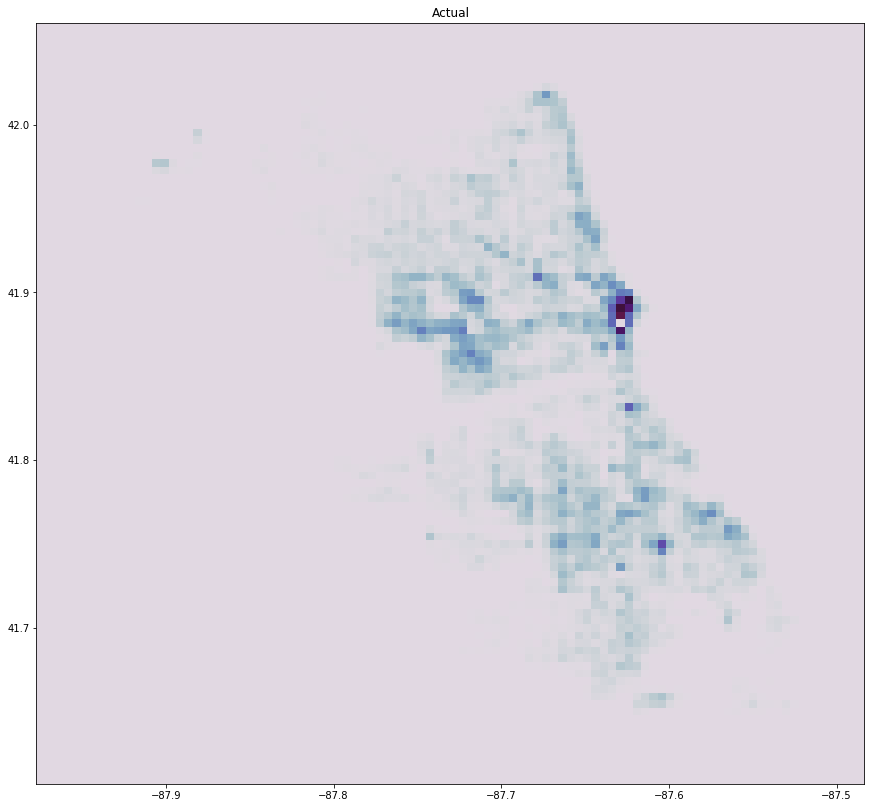

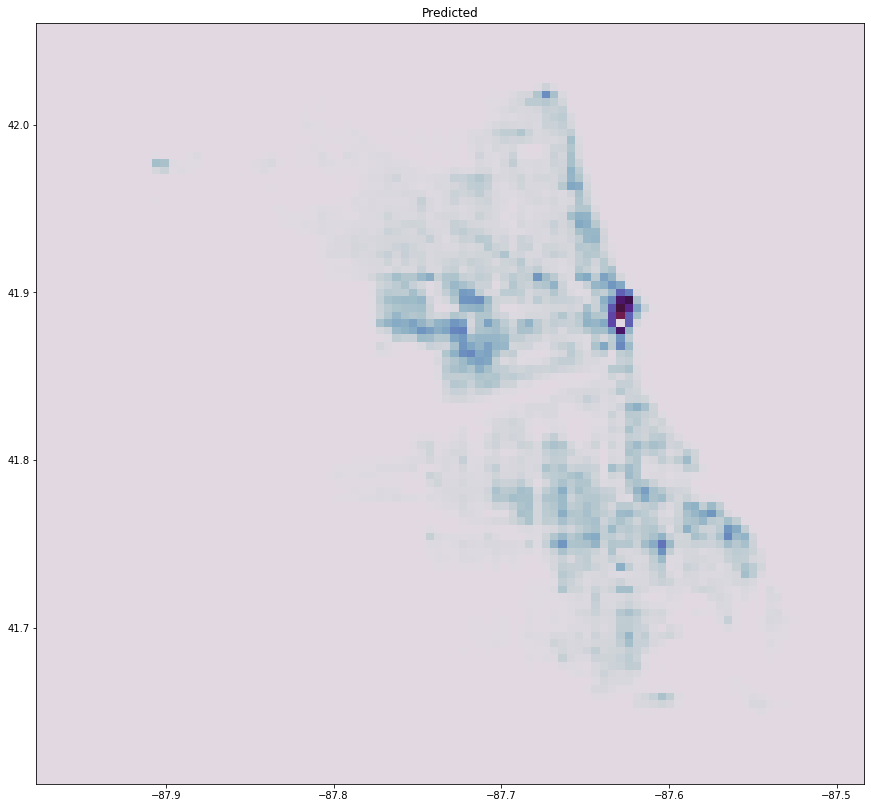

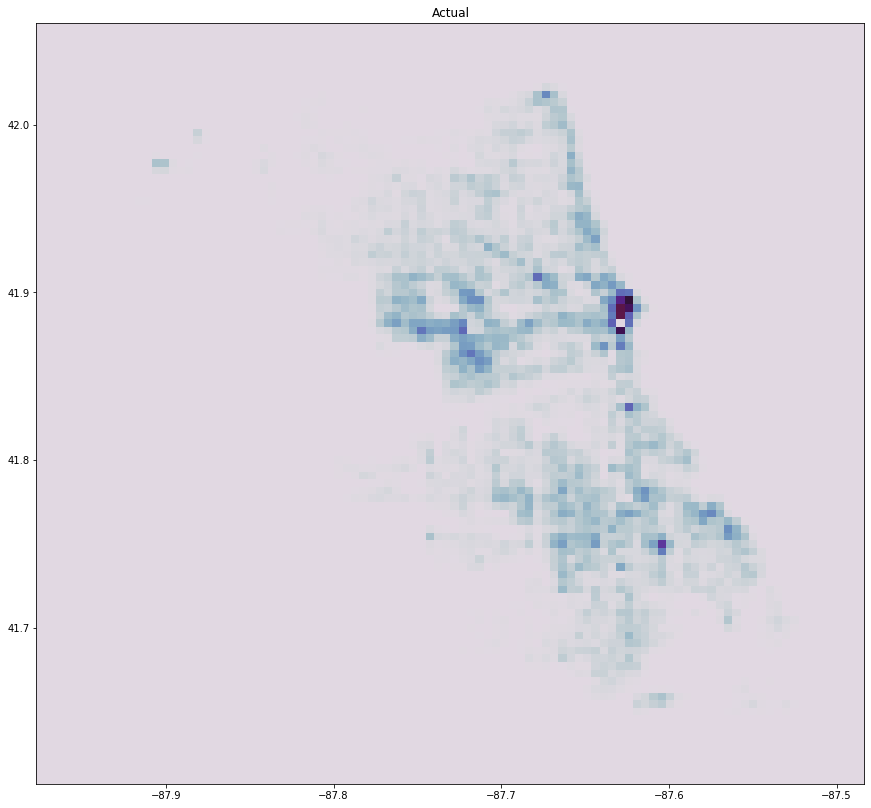

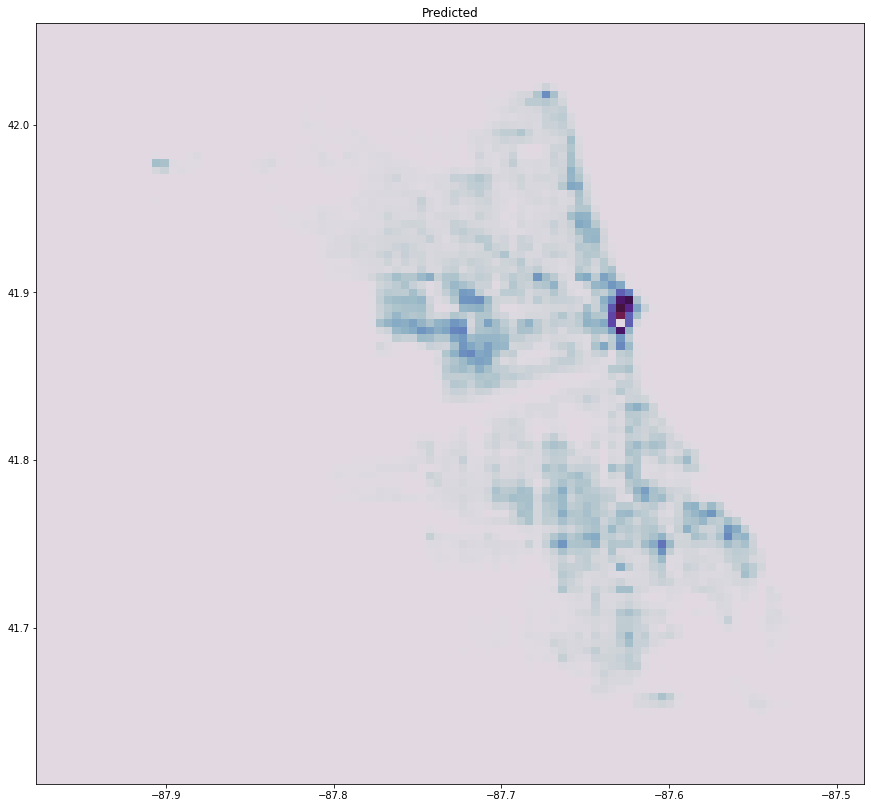

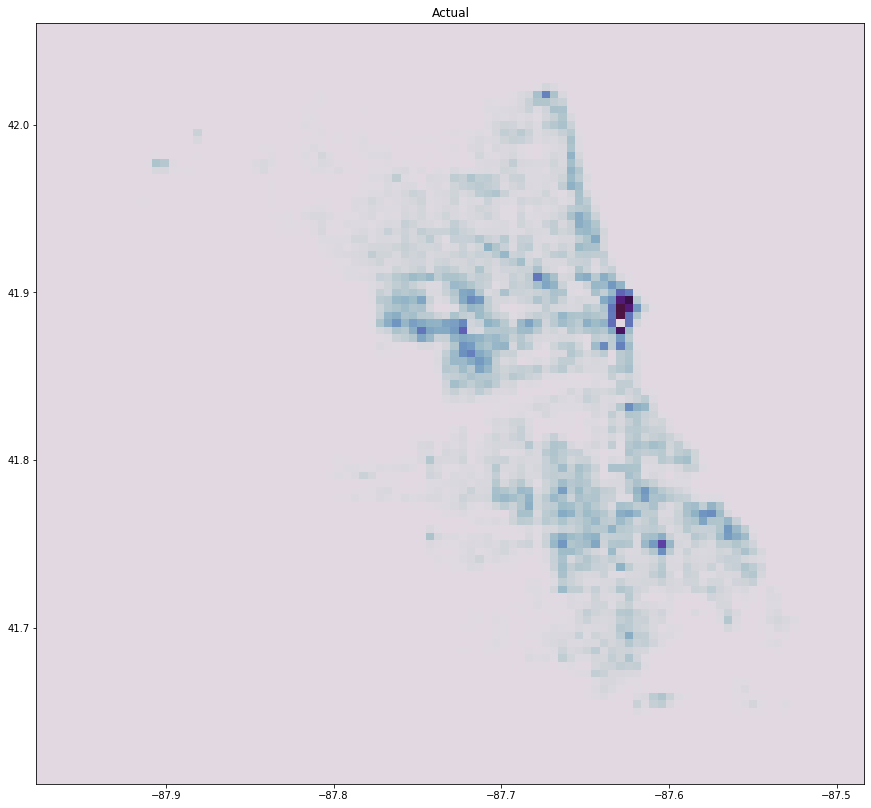

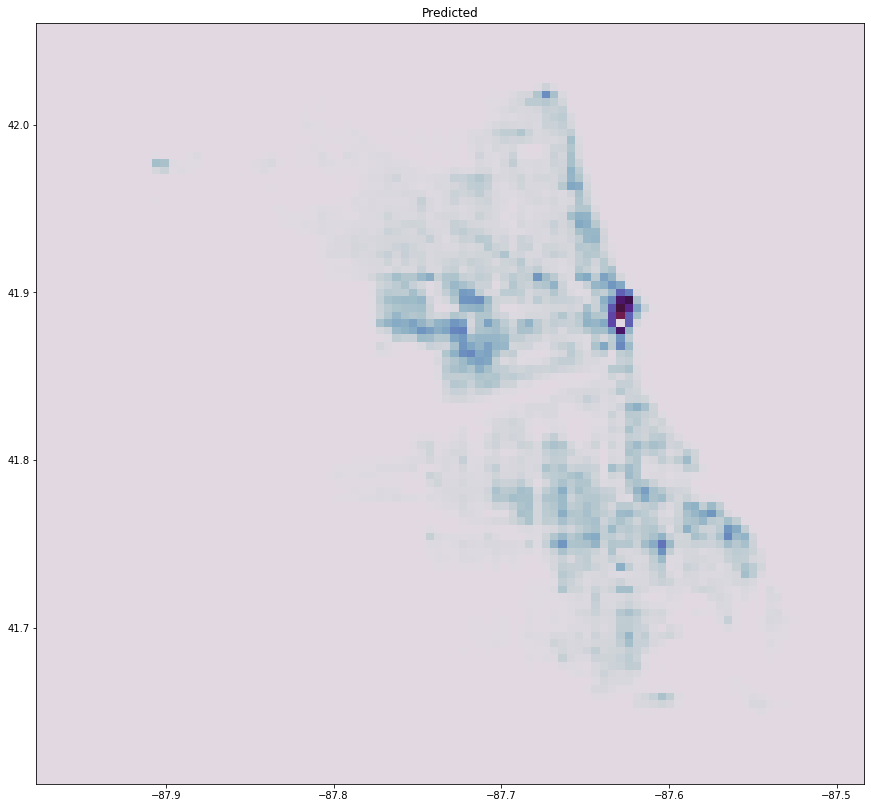

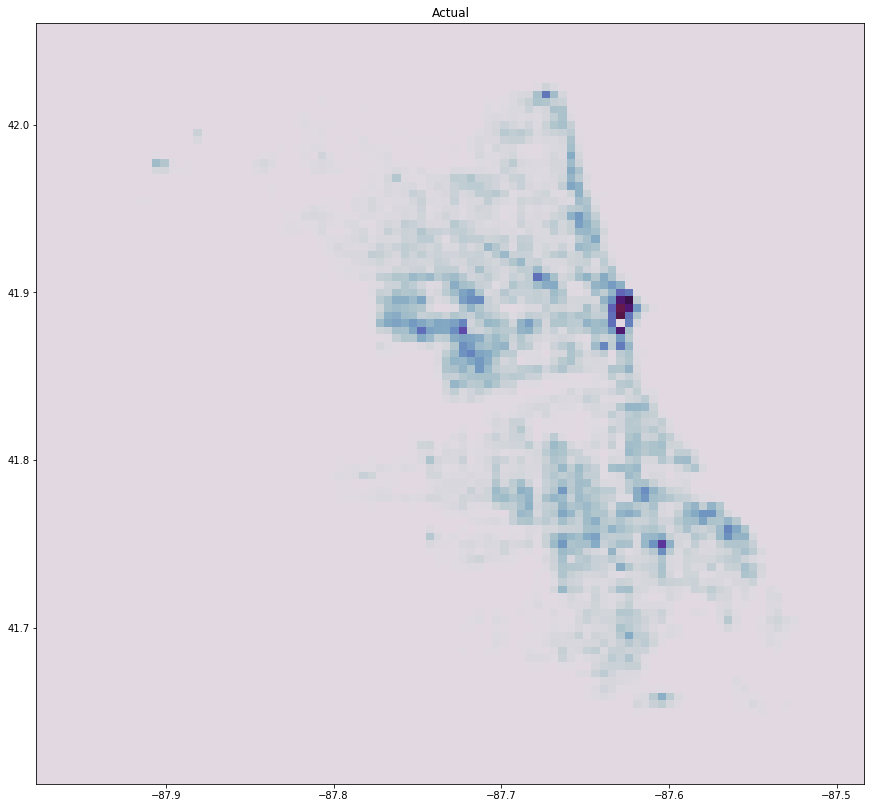

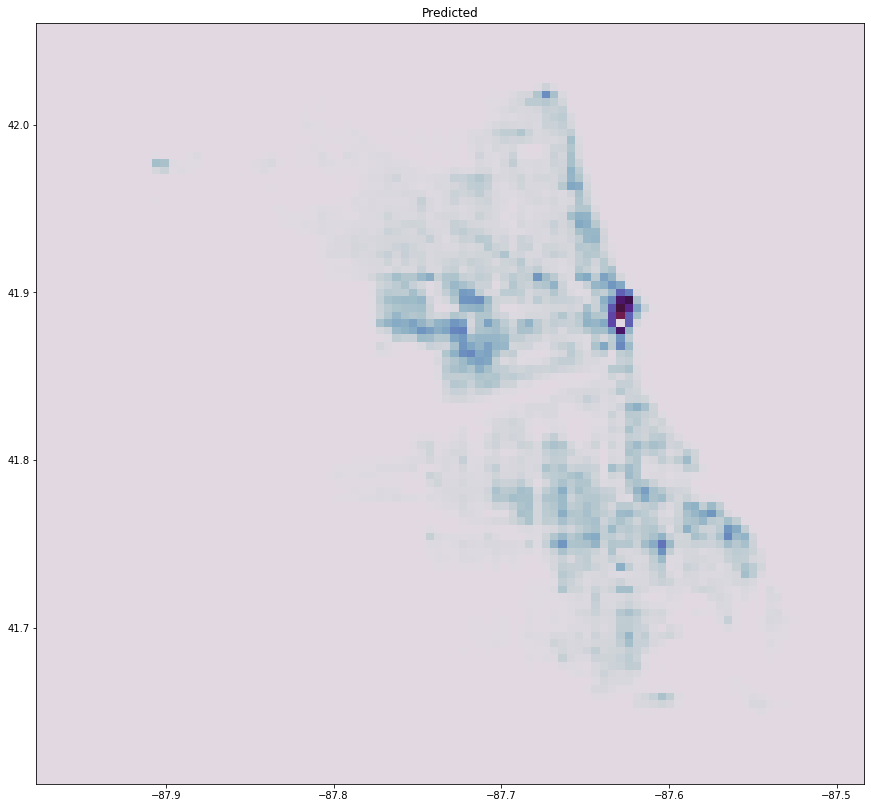

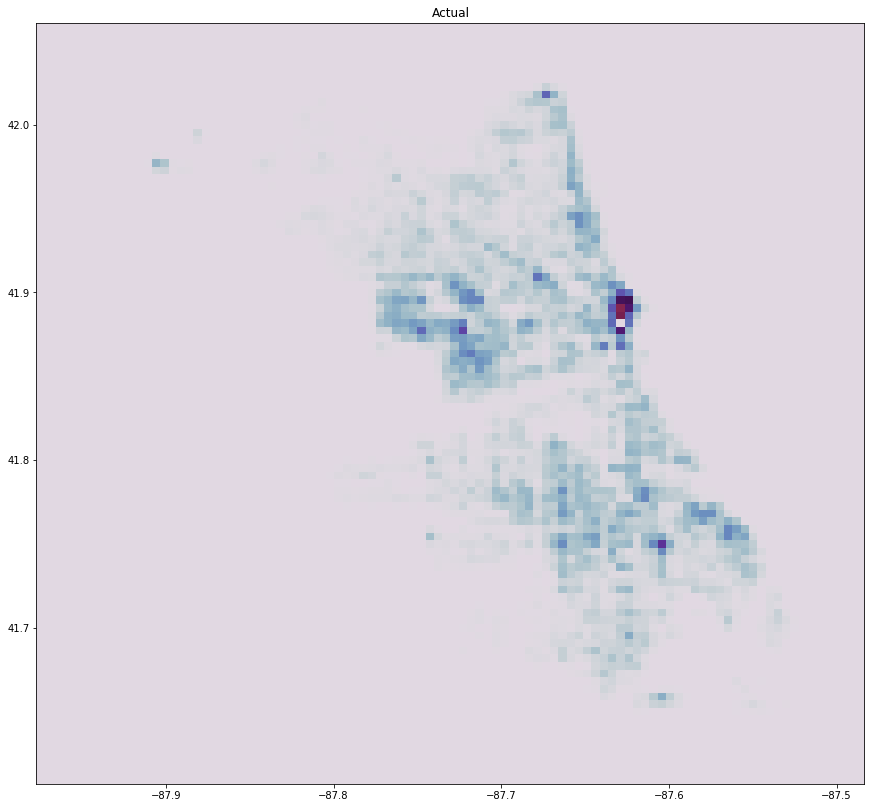

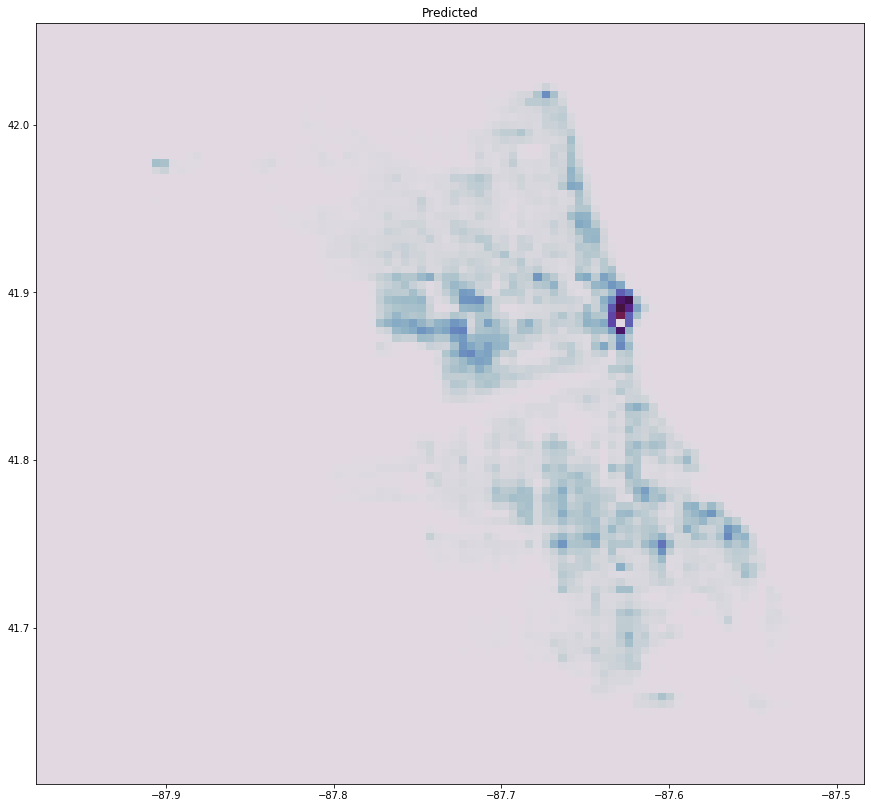

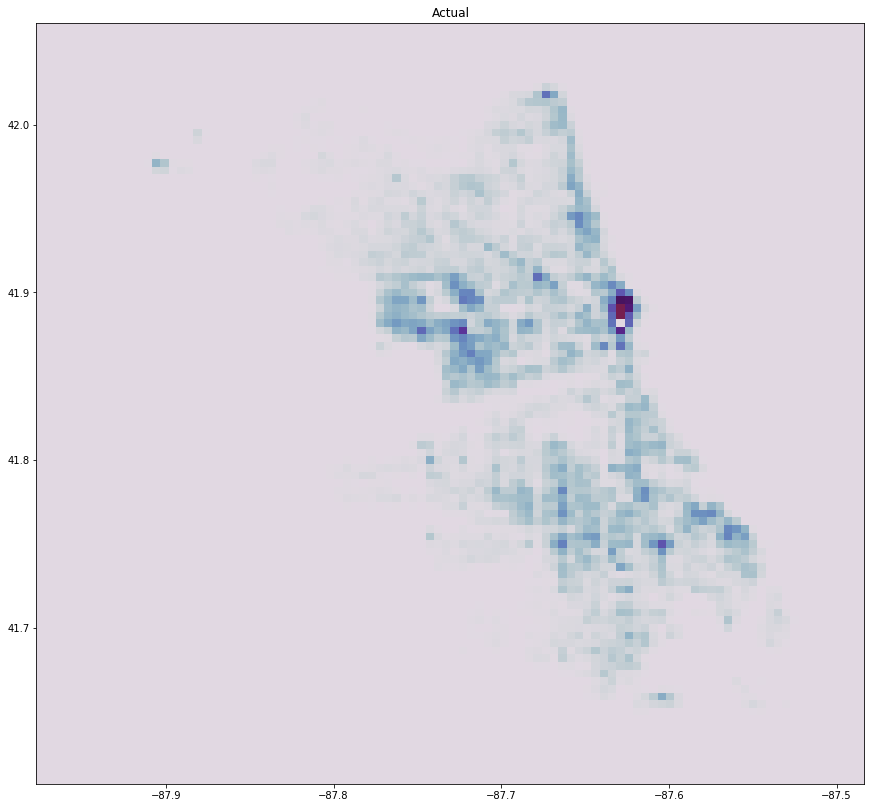

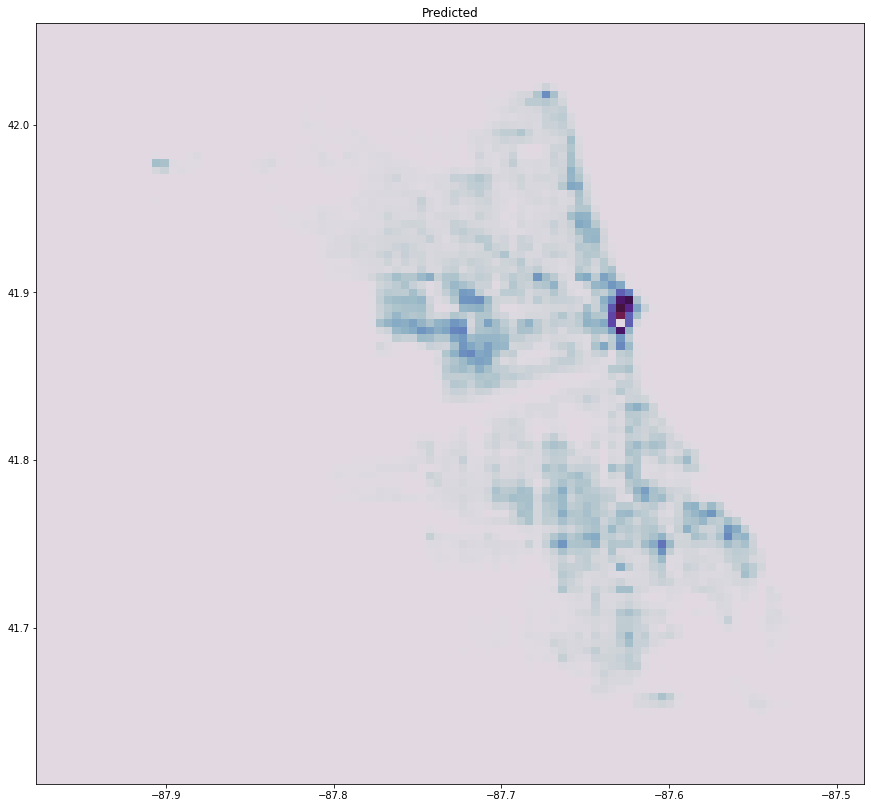

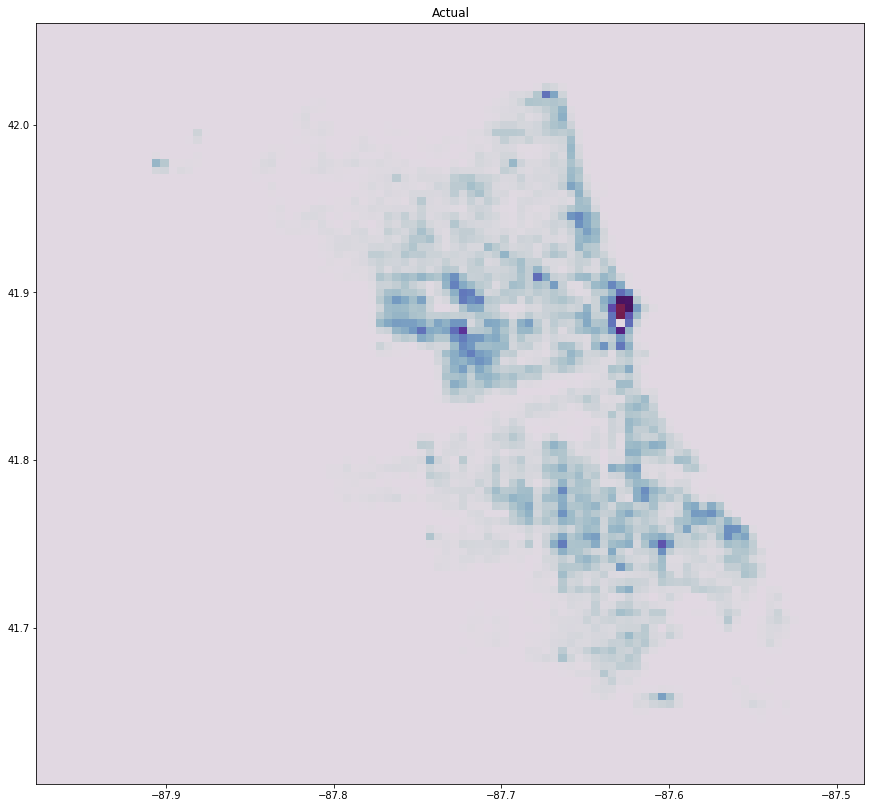

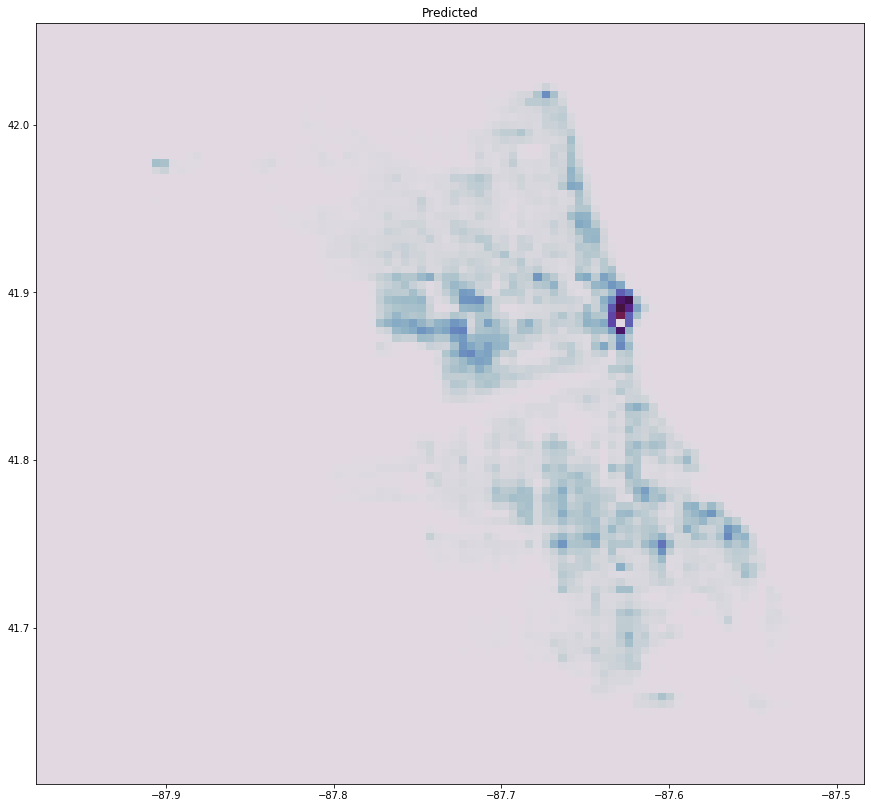

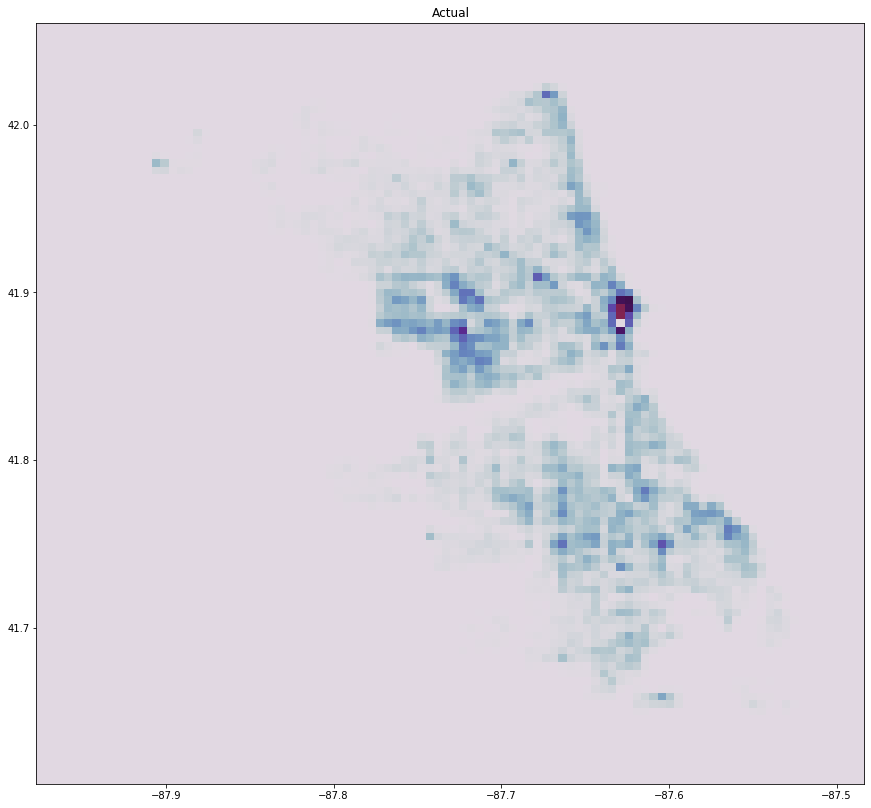

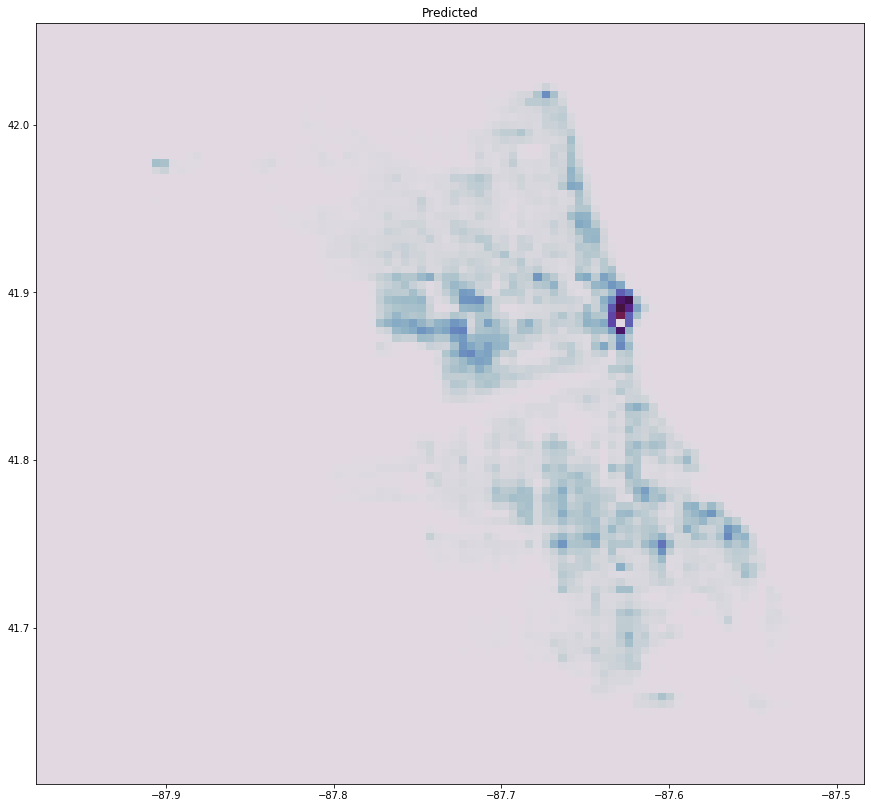

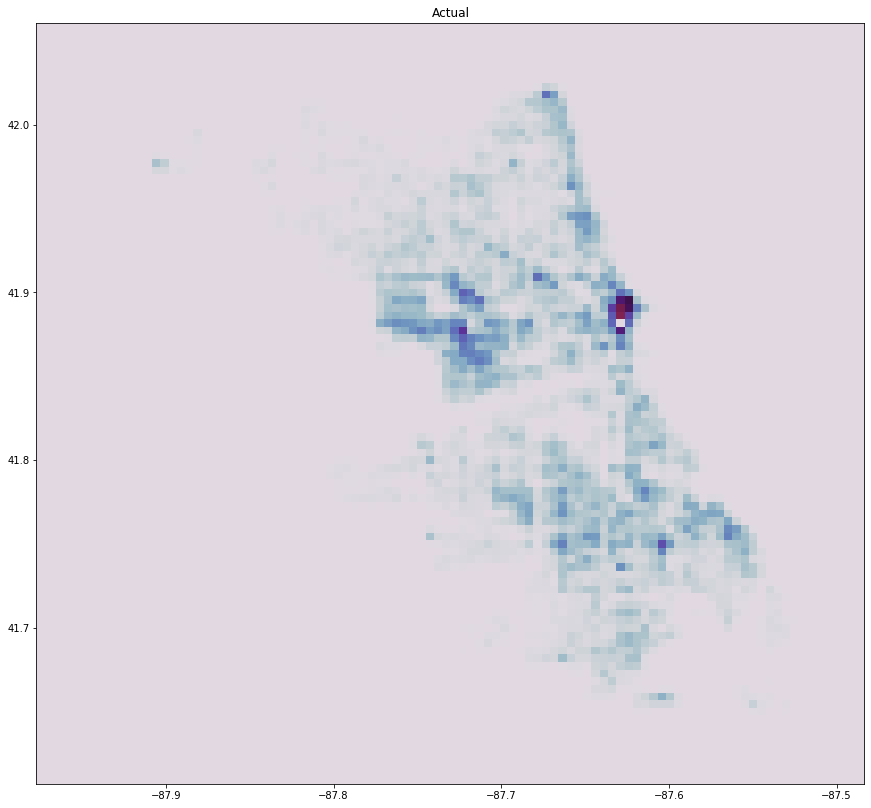

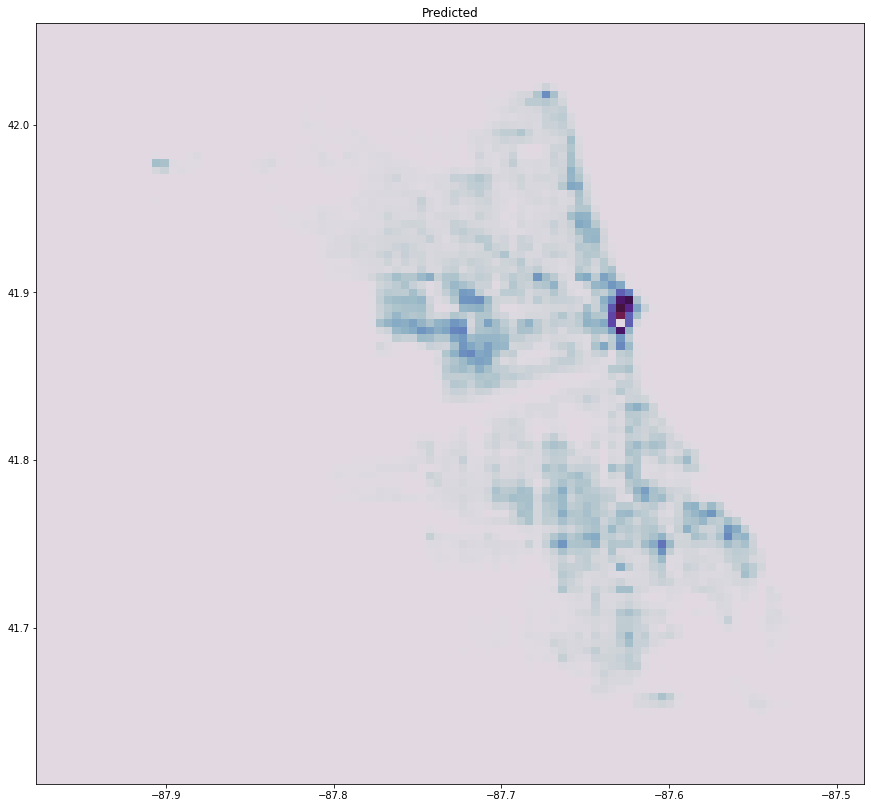

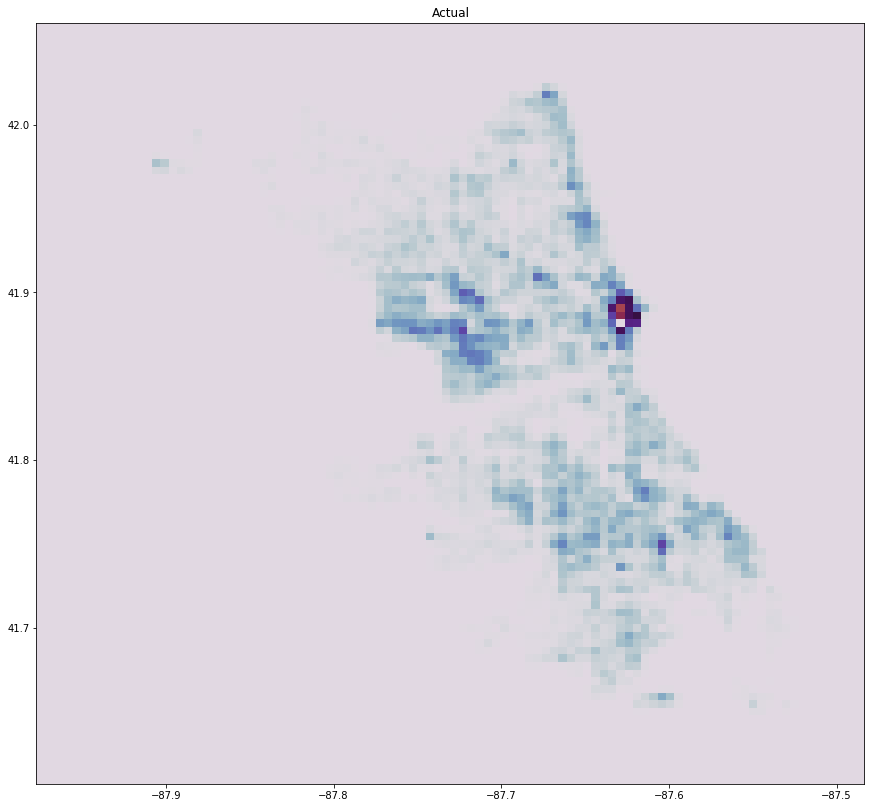

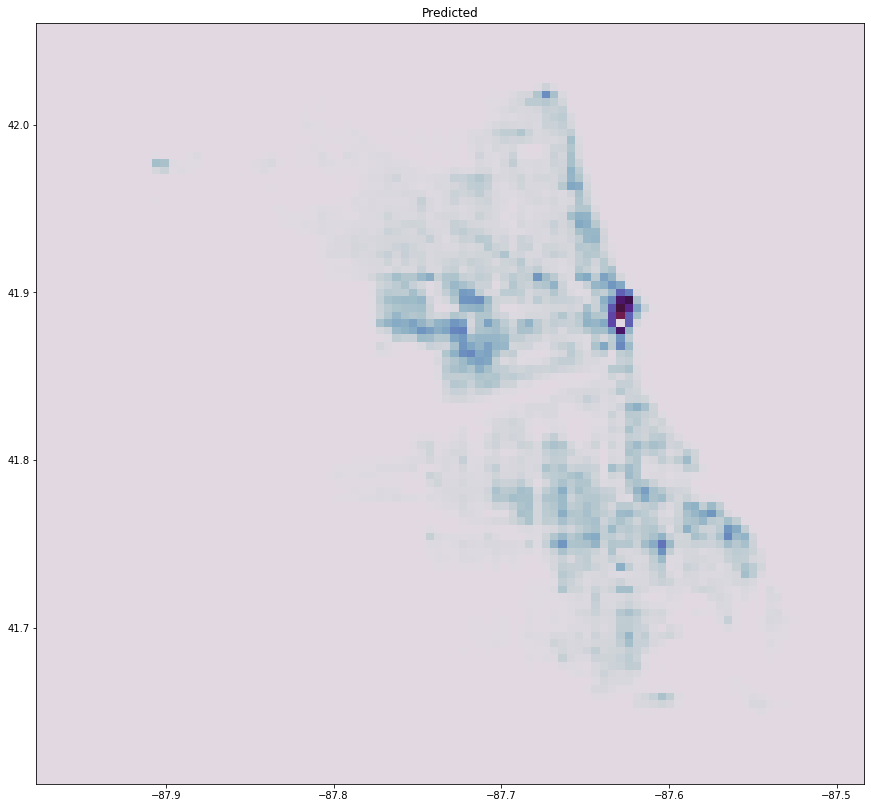

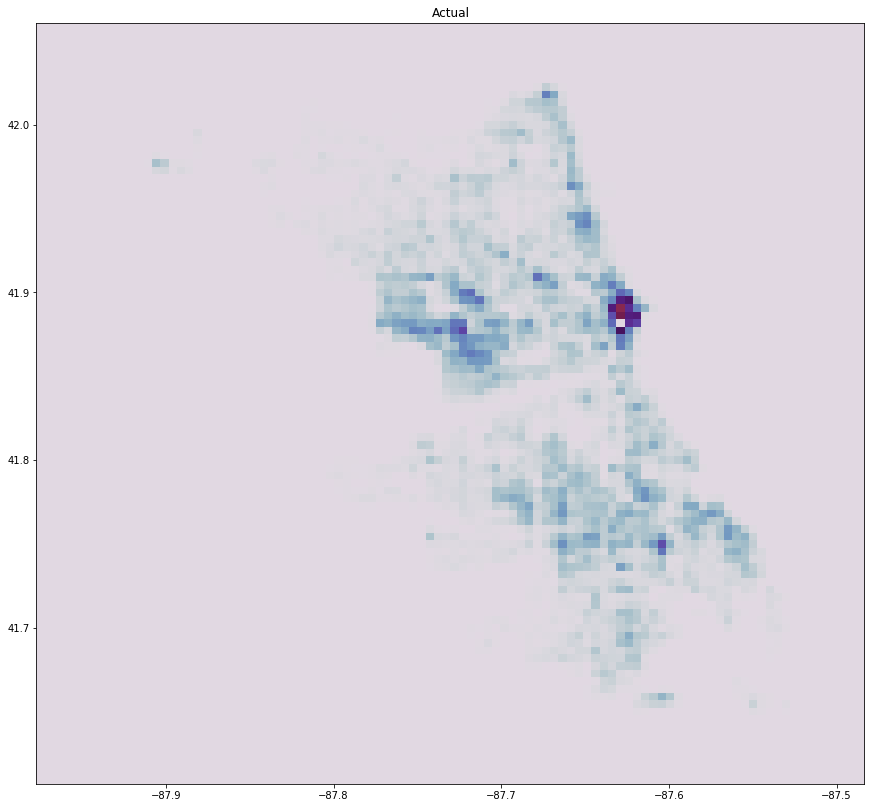

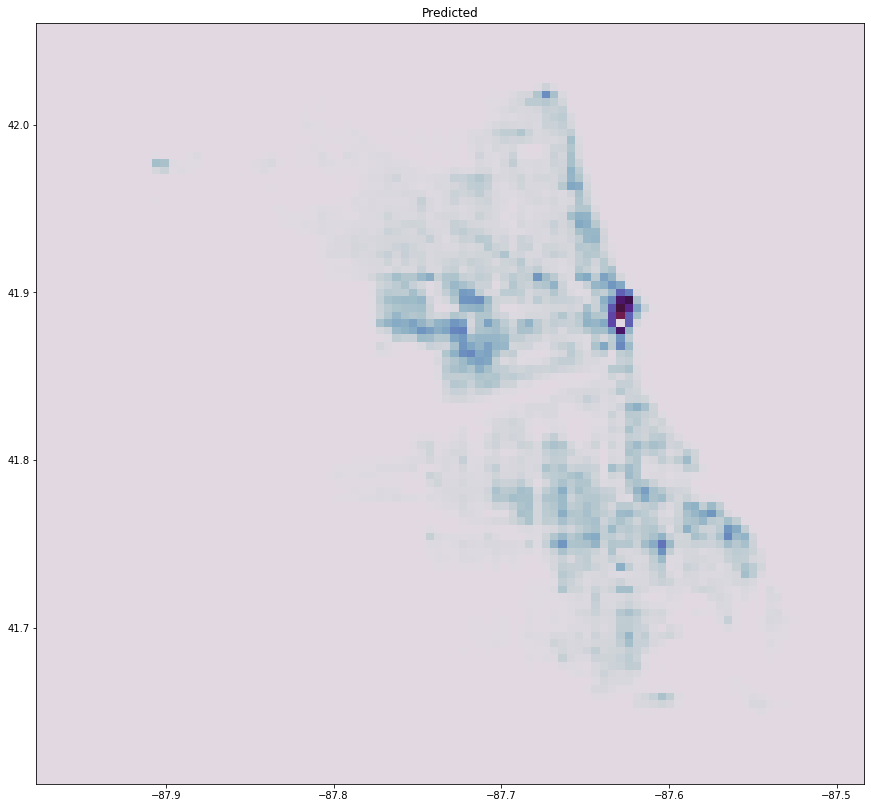

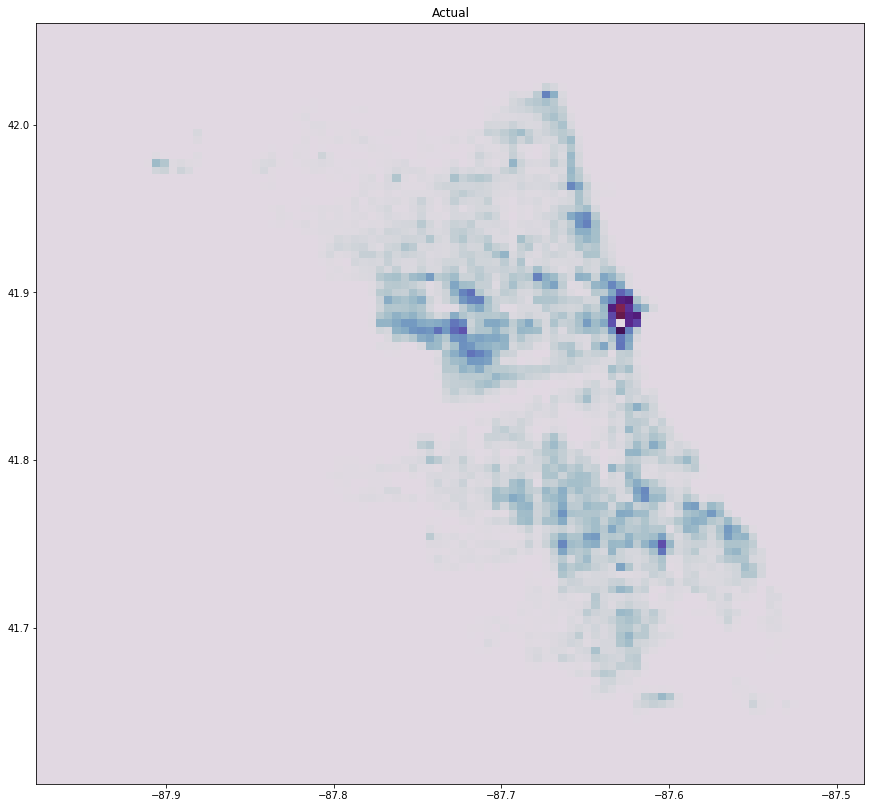

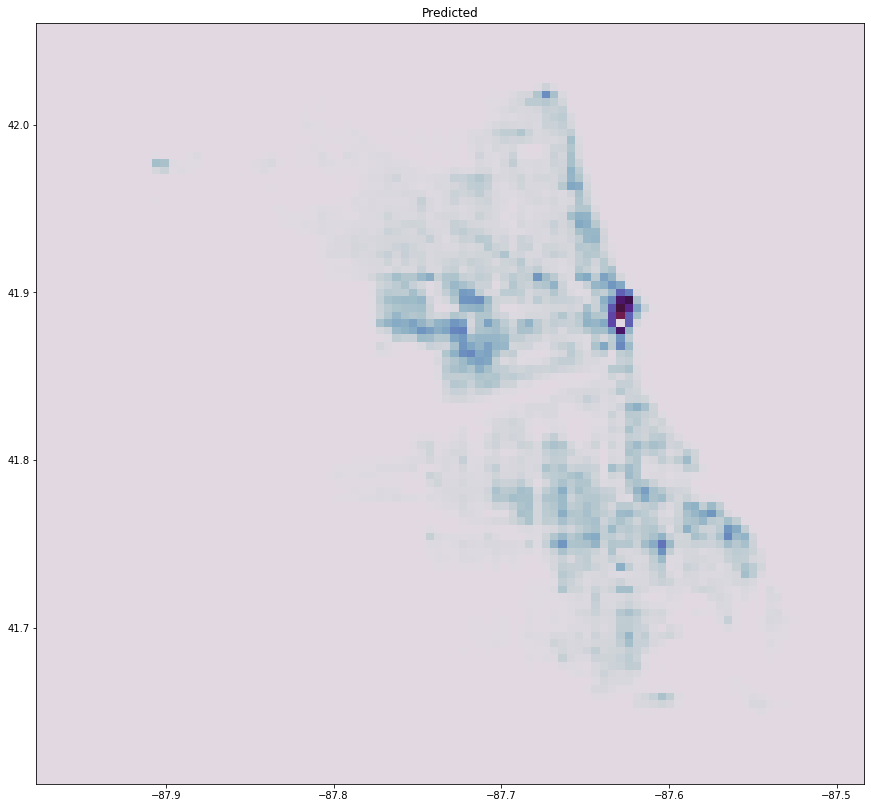

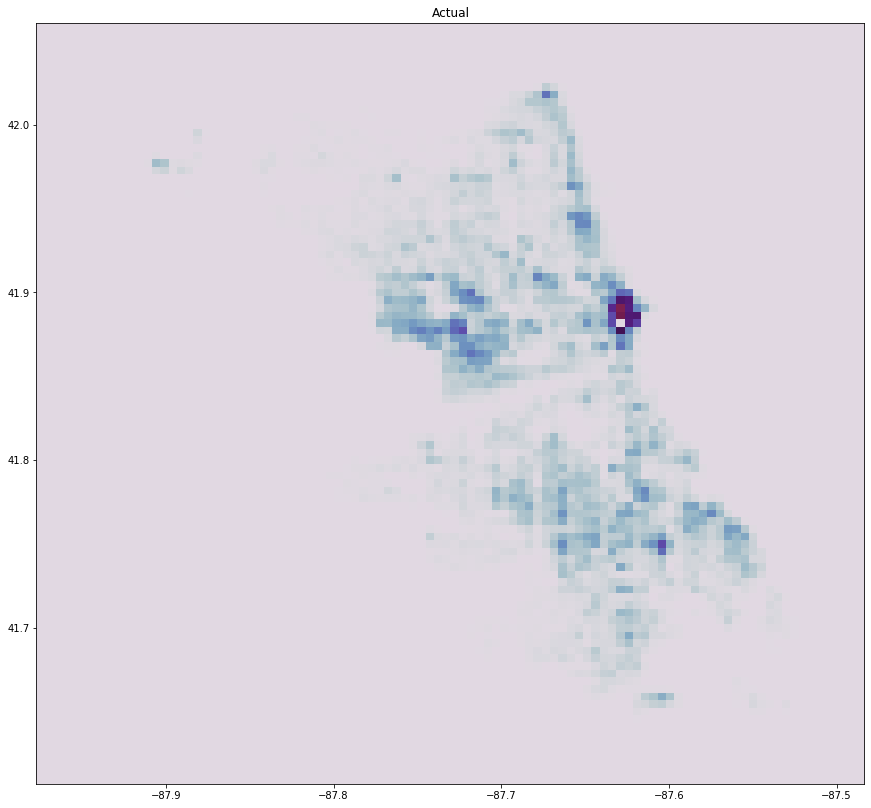

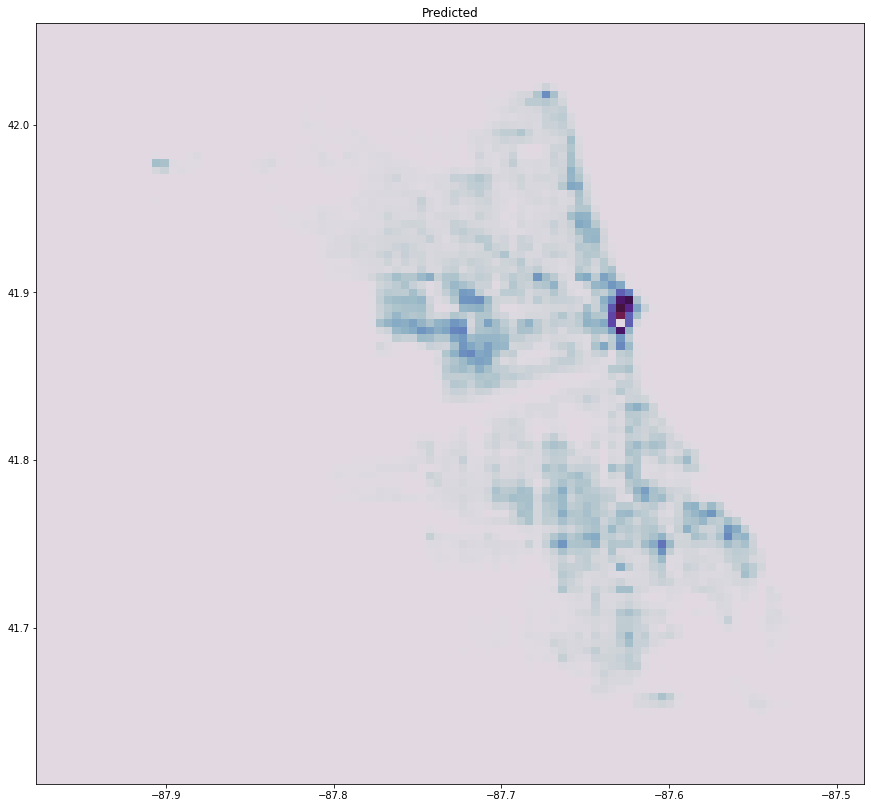

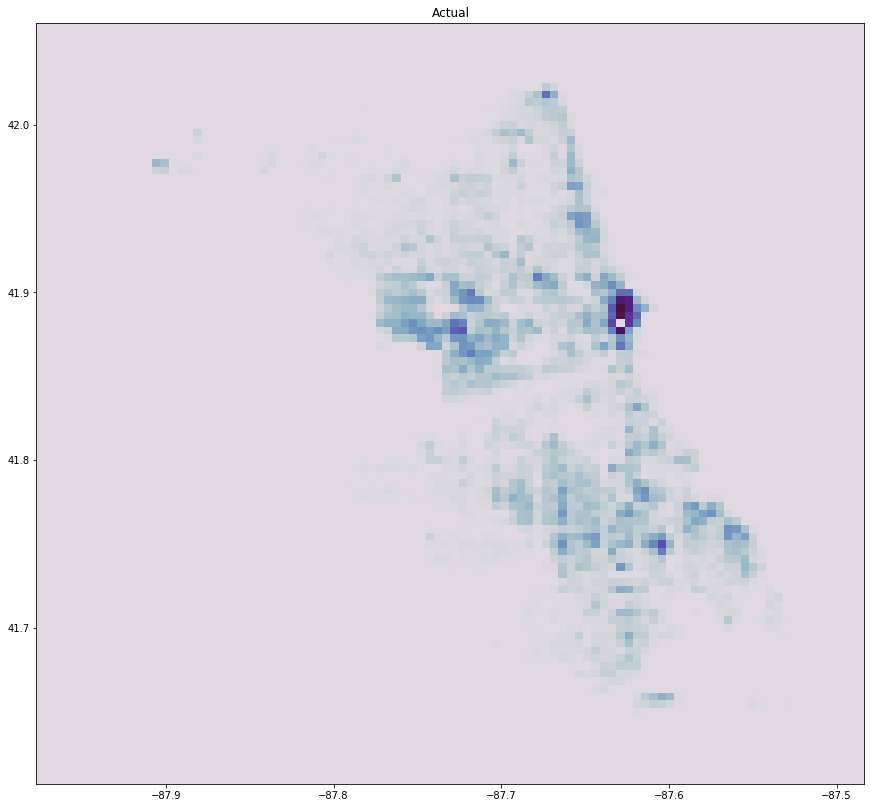

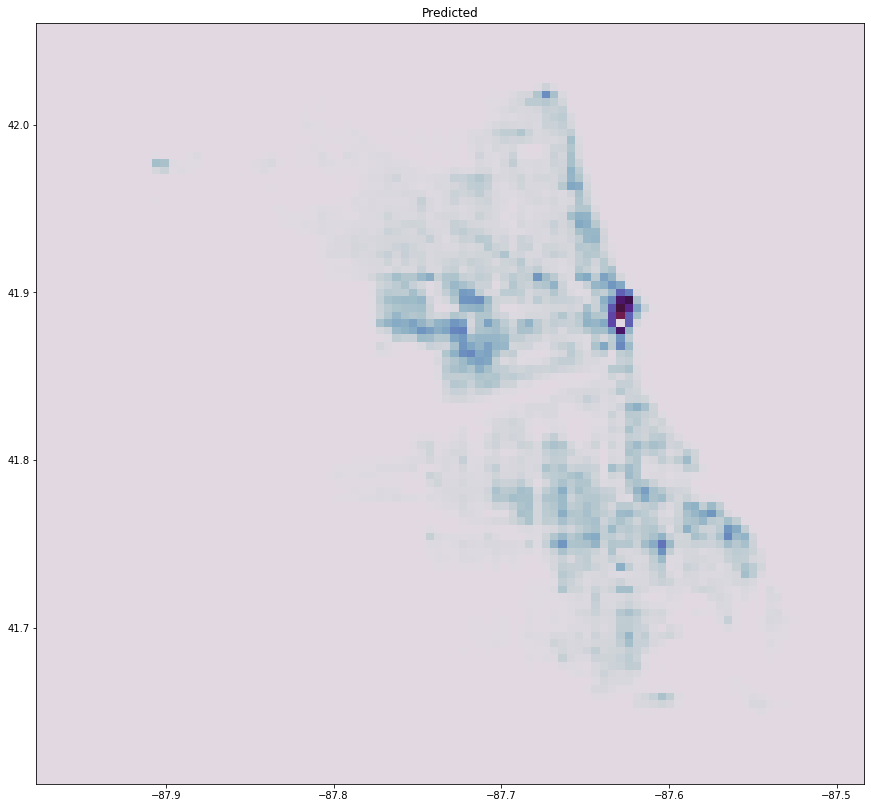

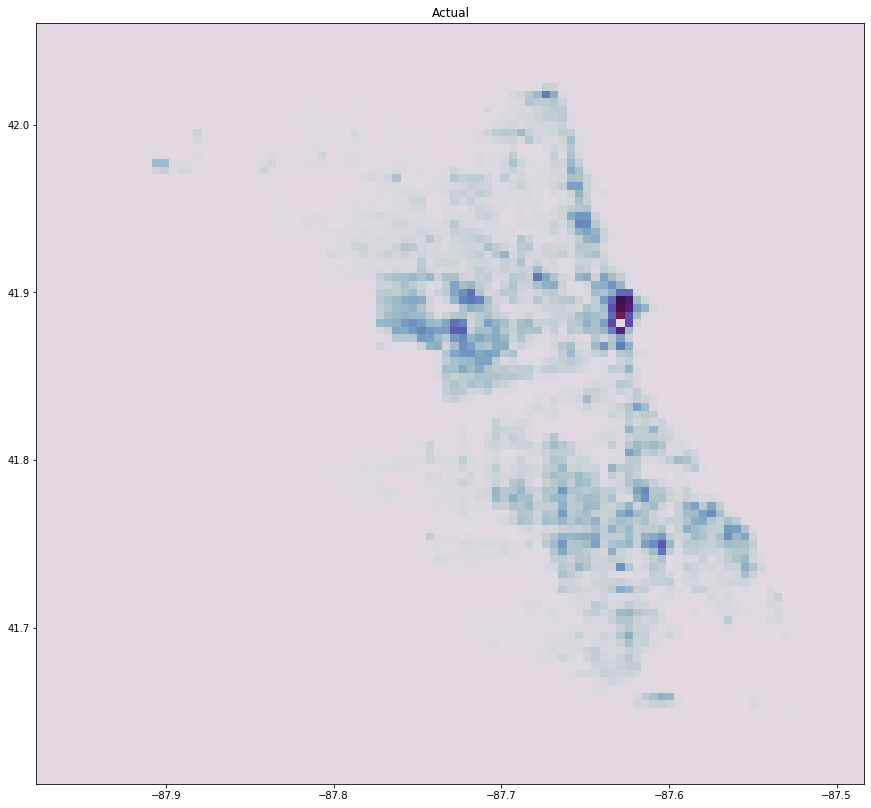

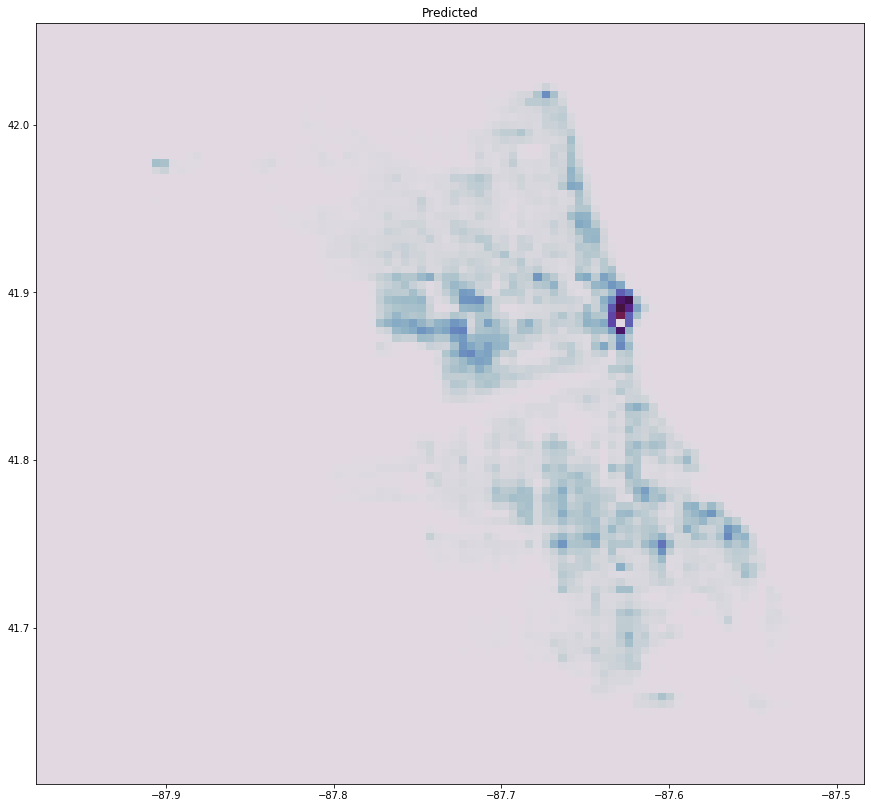

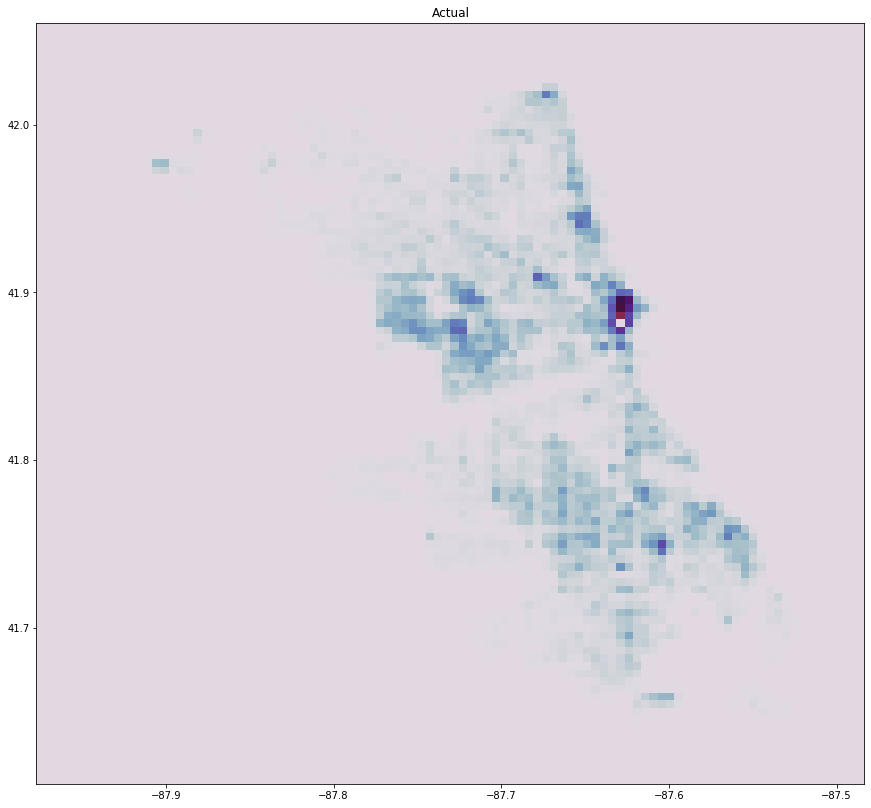

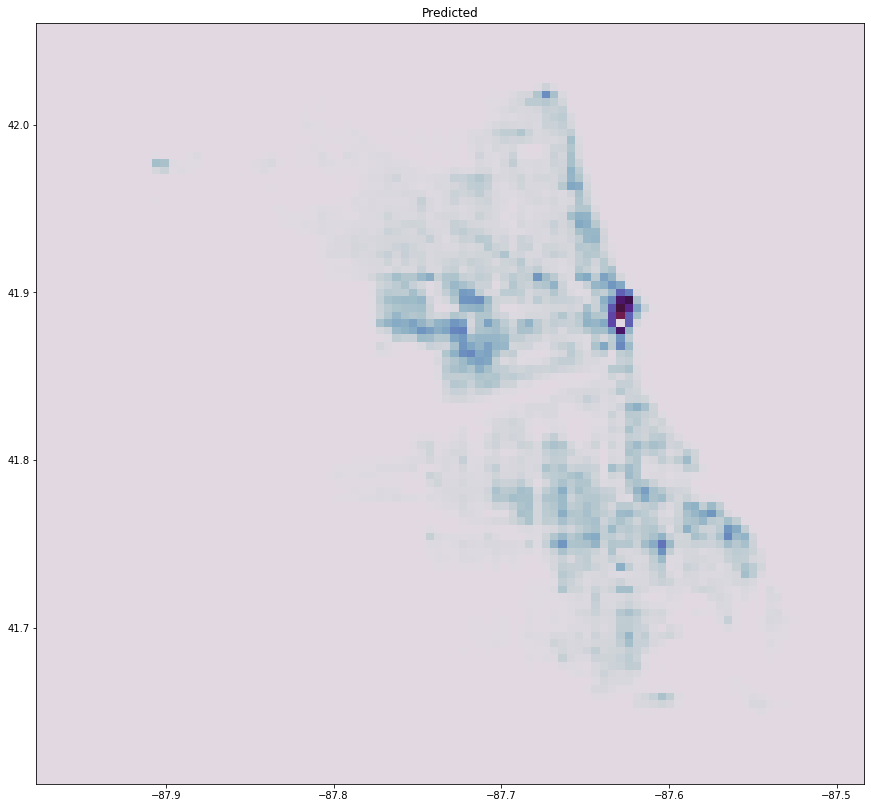

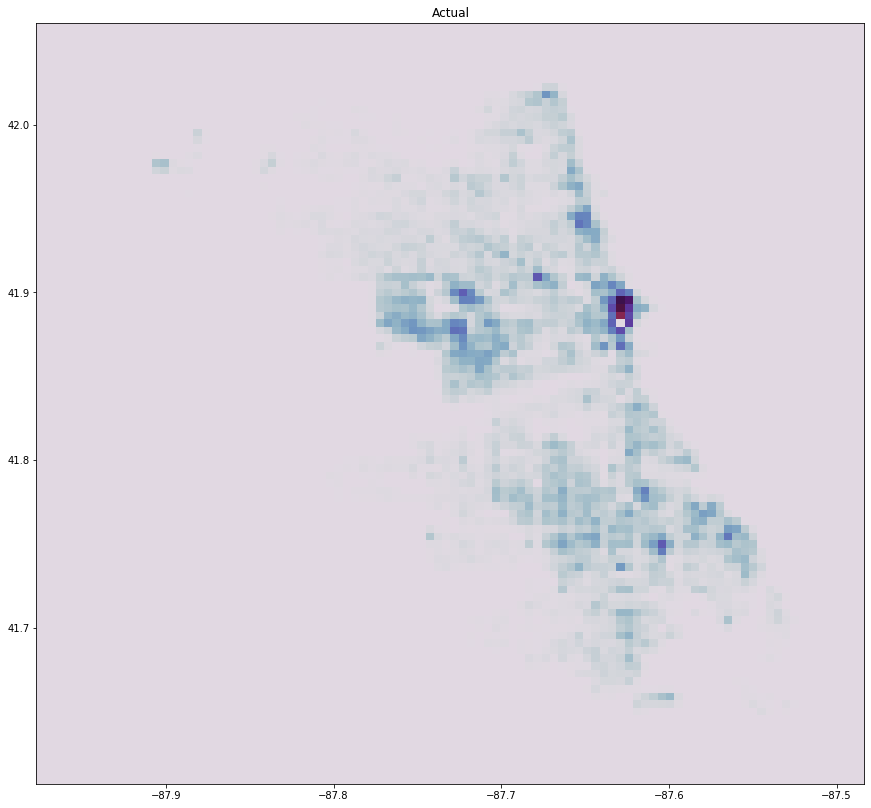

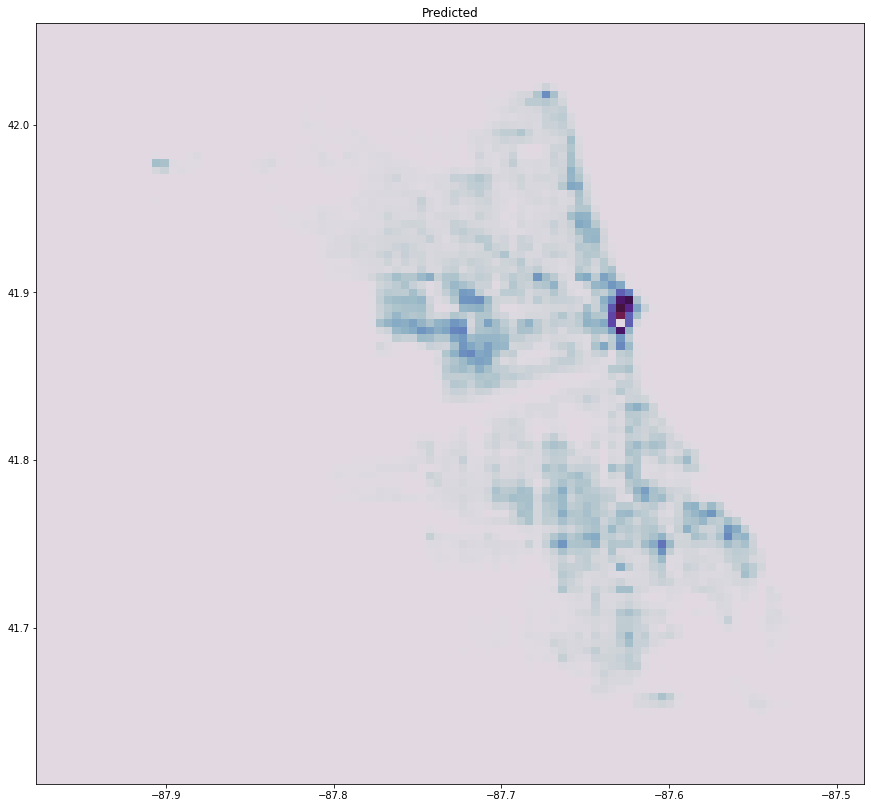

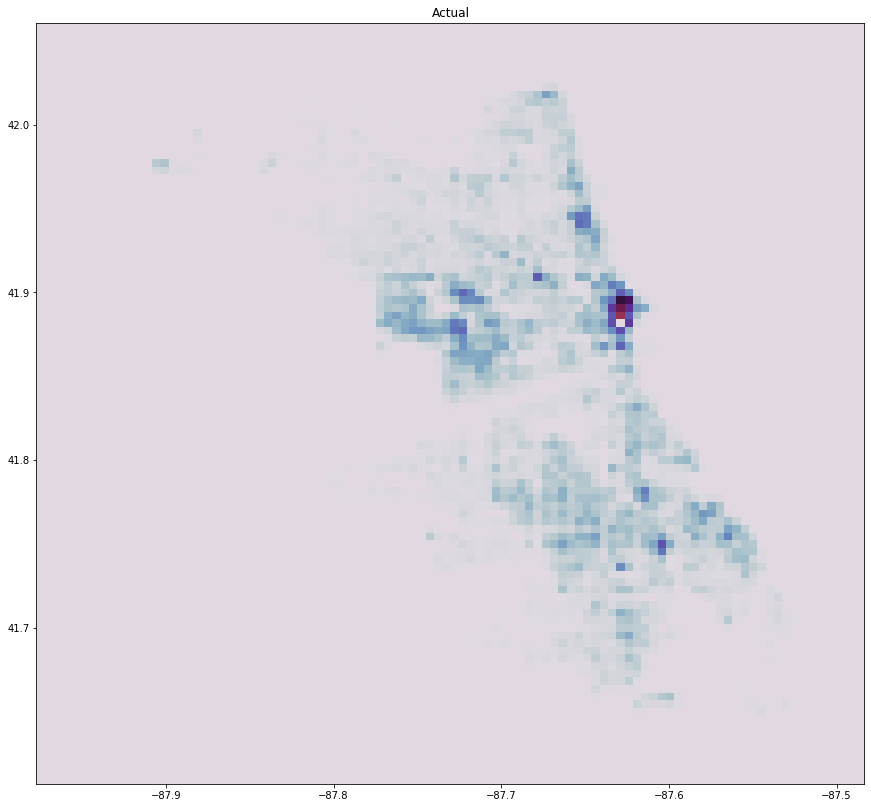

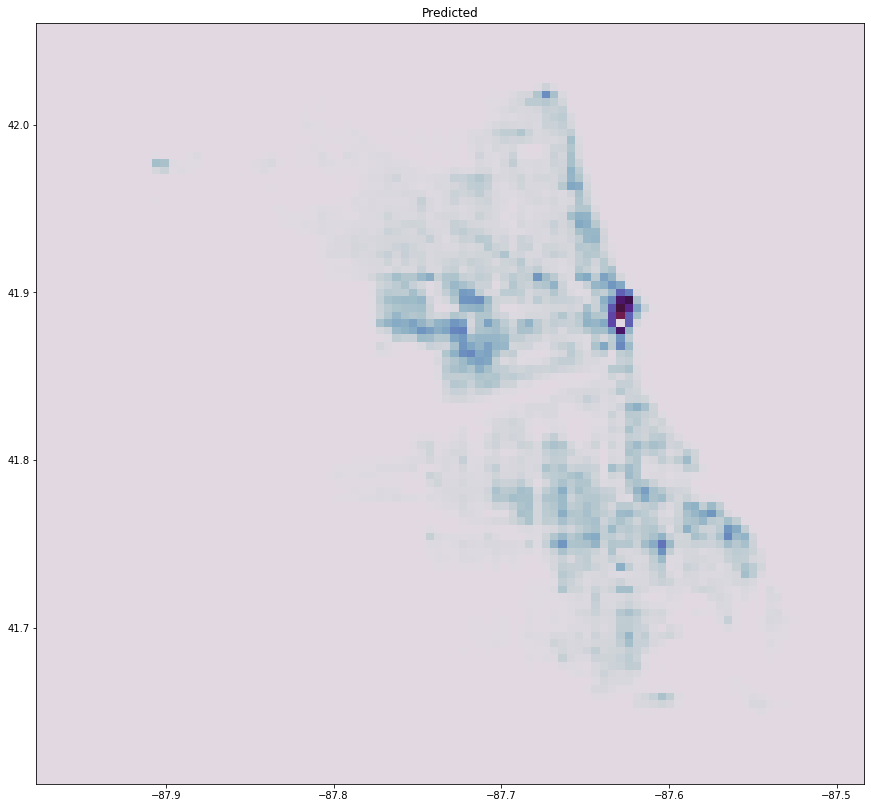

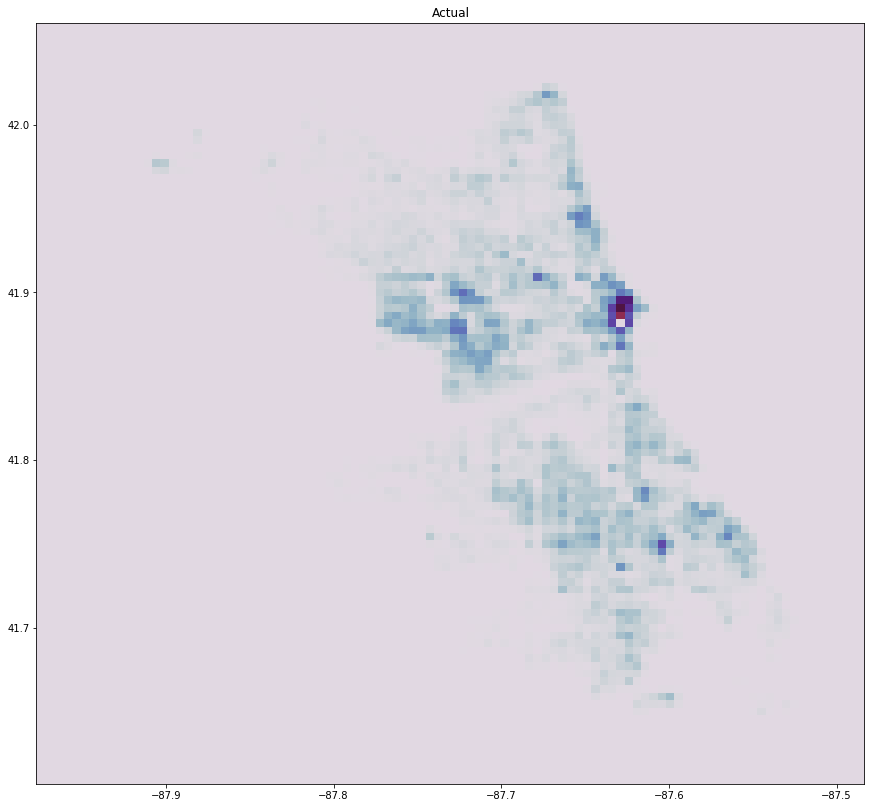

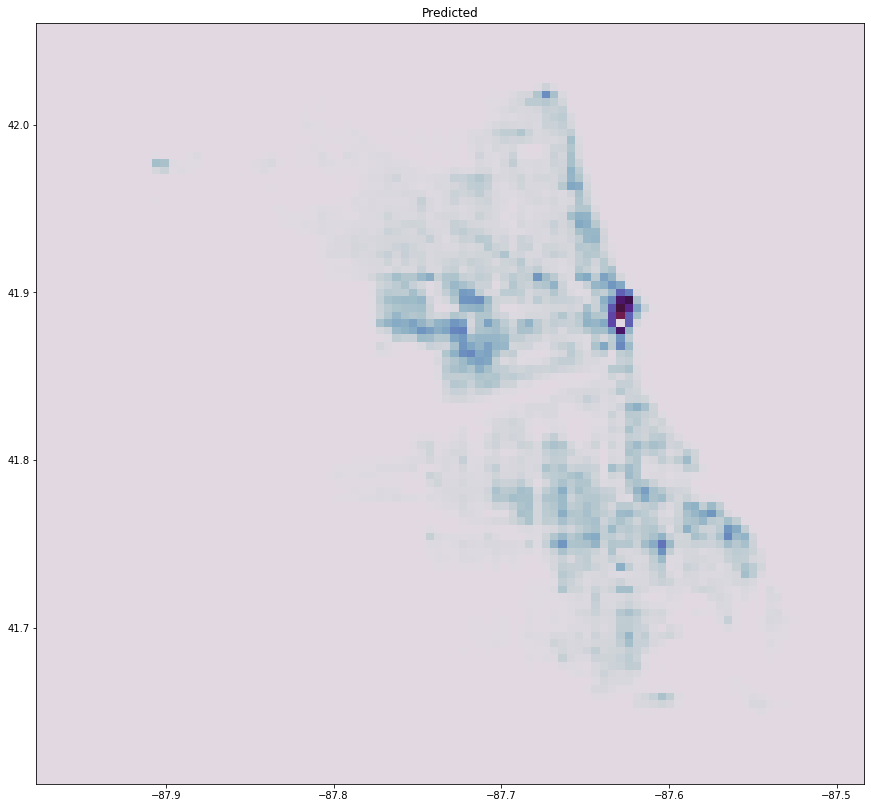

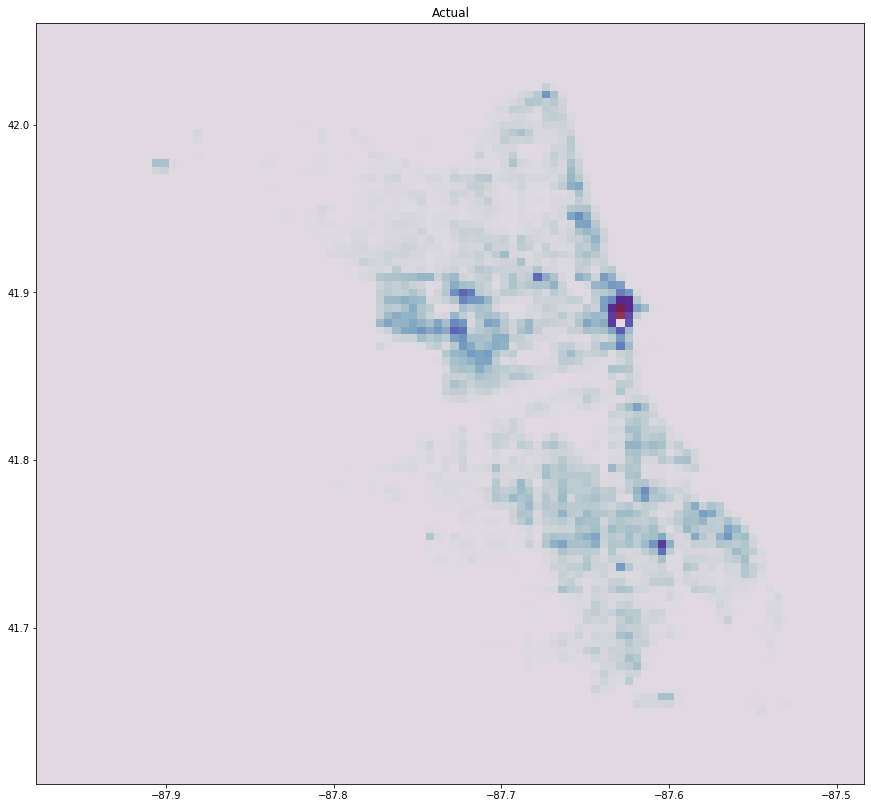

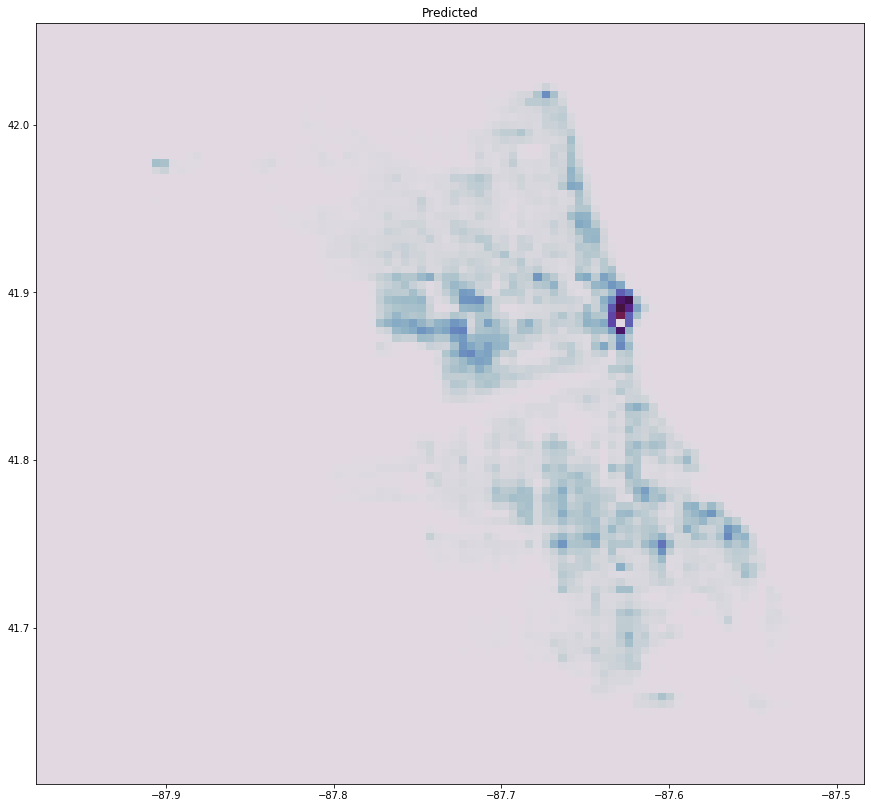

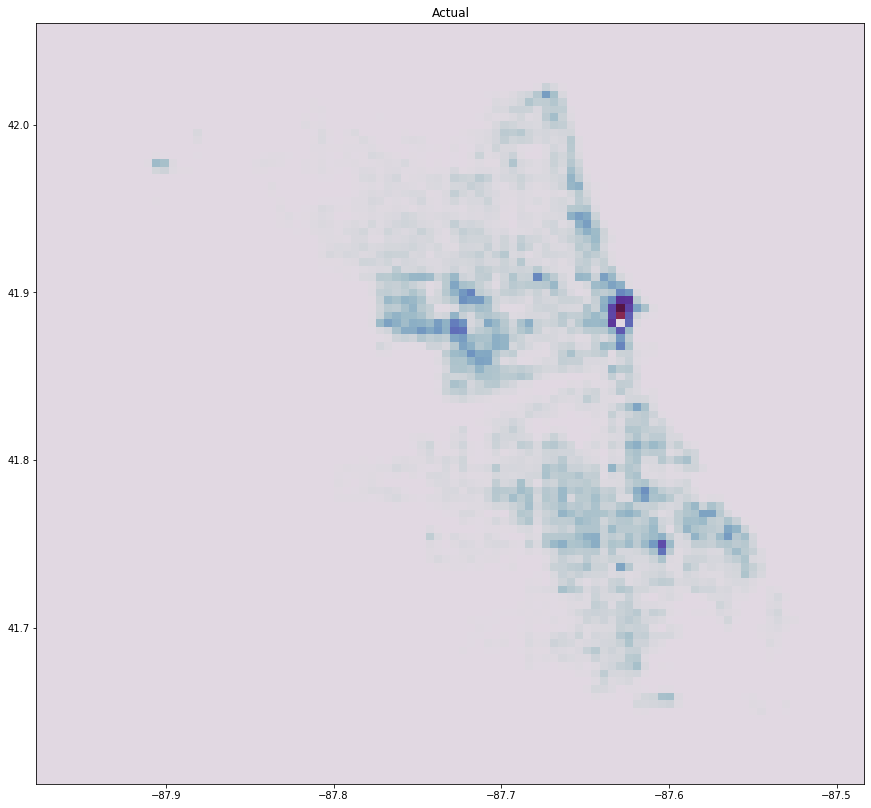

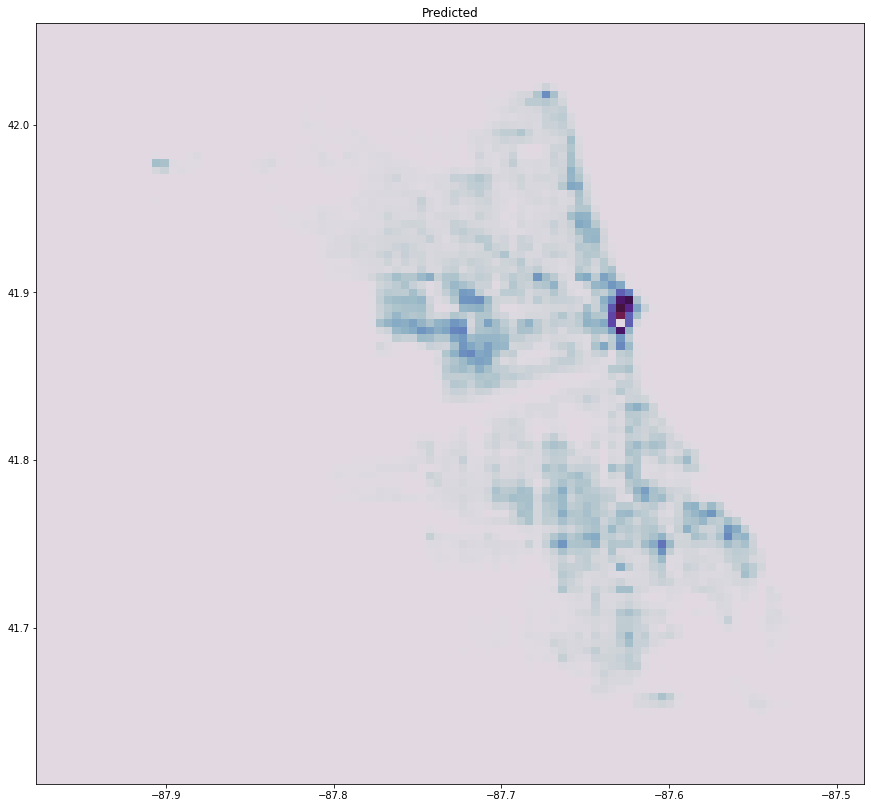

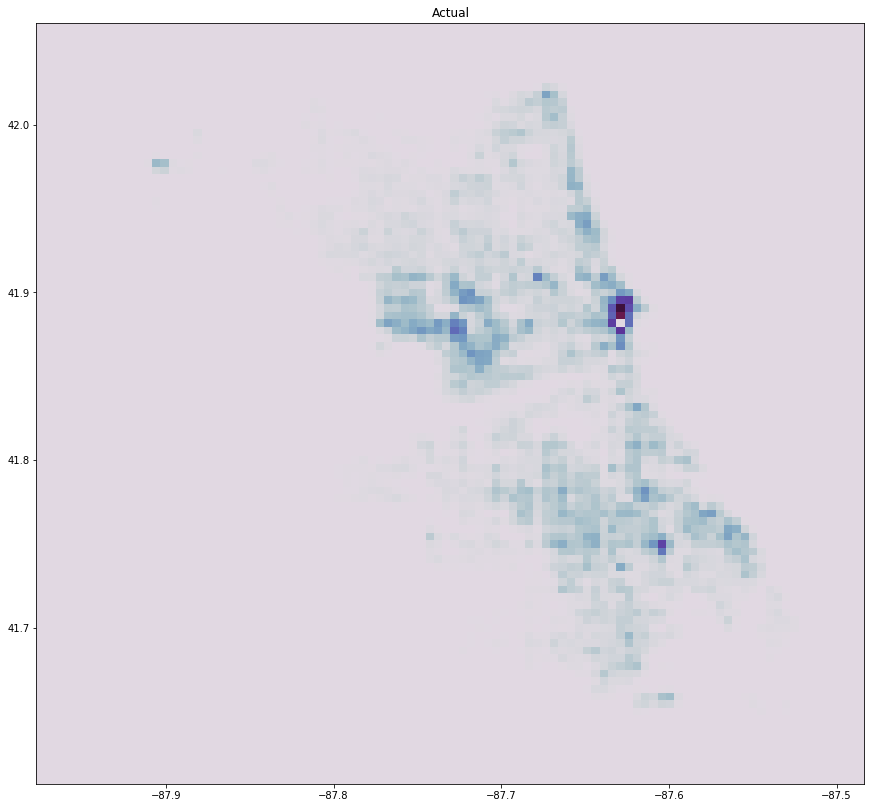

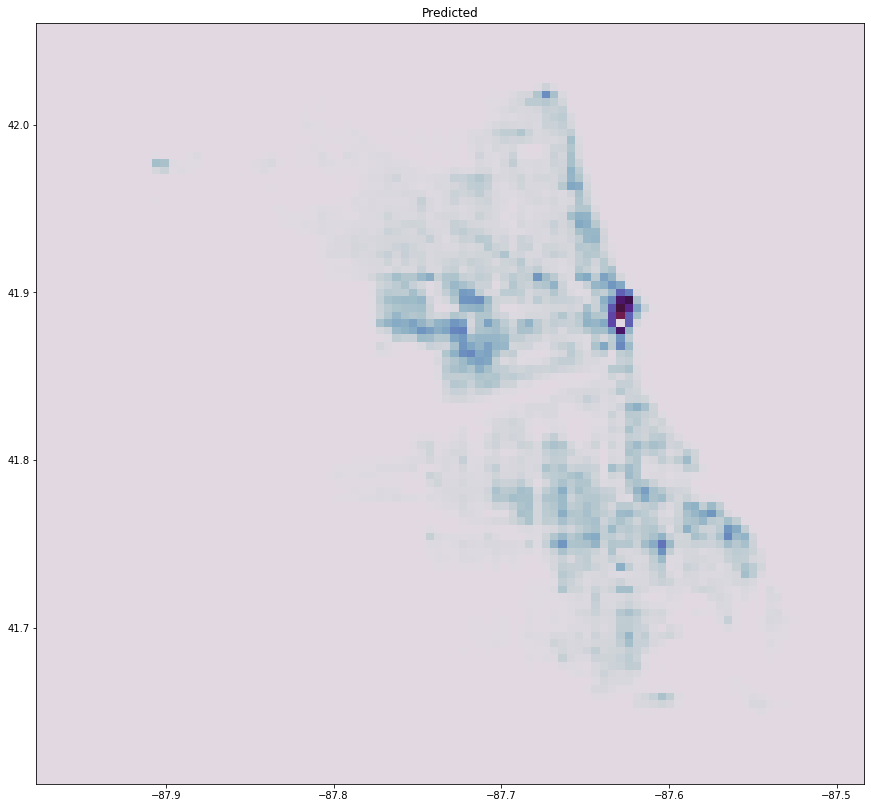

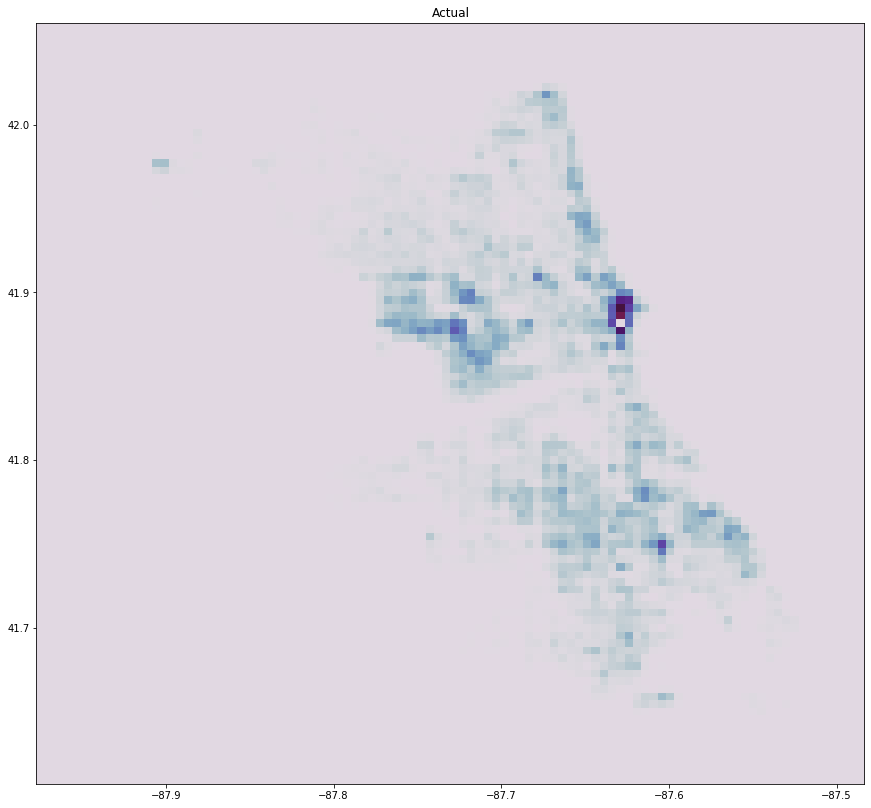

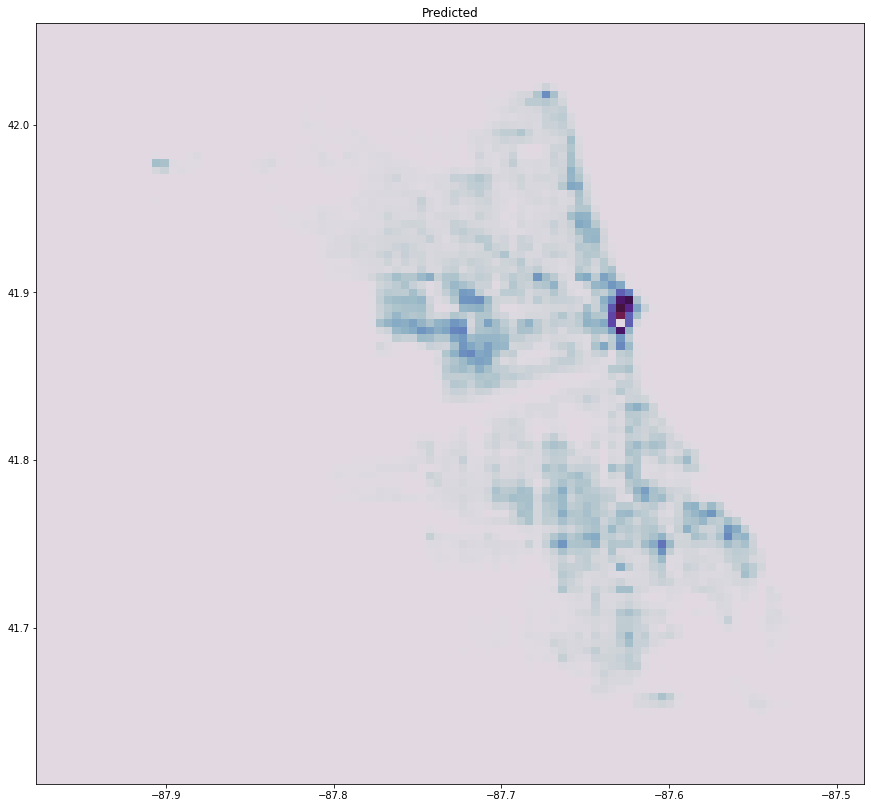

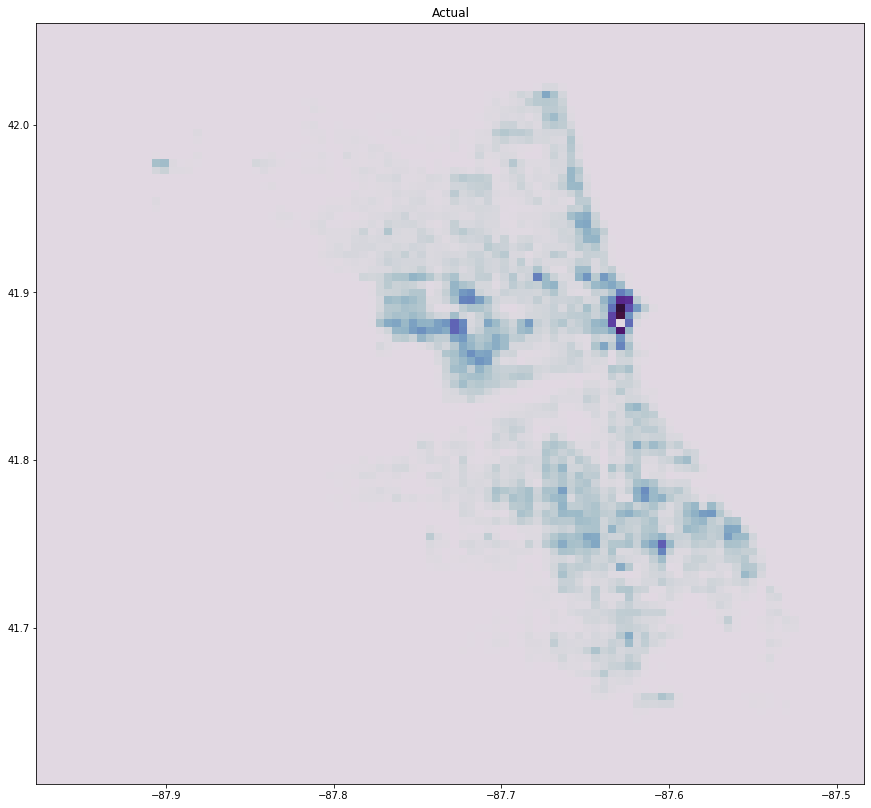

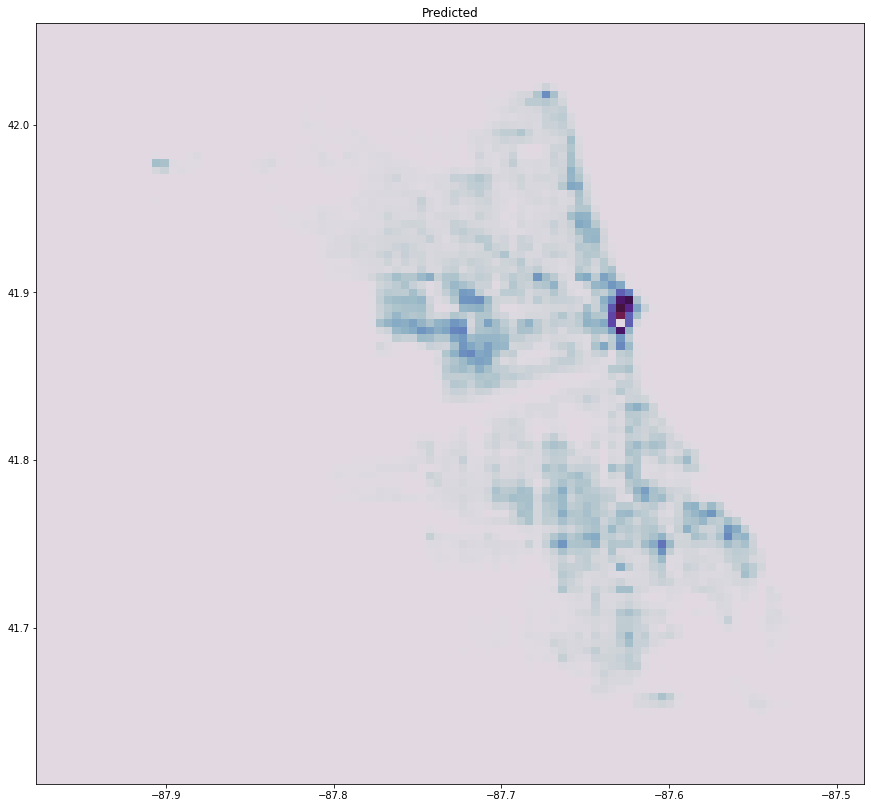

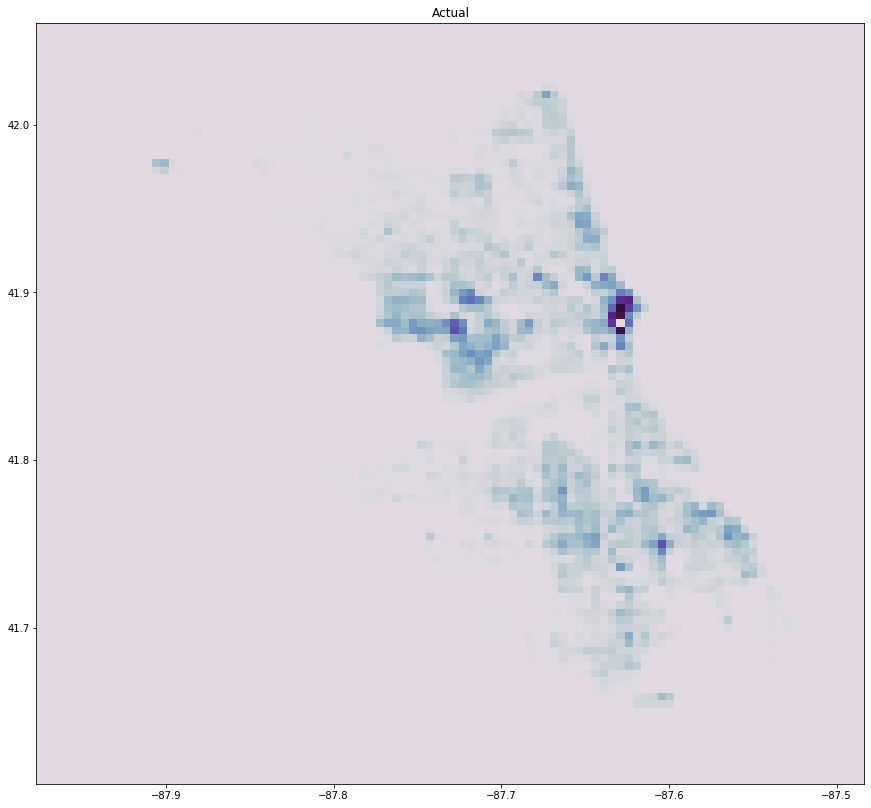

In [60]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepFromLast in range(Y_valid.shape[0]):
    plt.figure(figsize=(18, 14))
    plt.title('Predicted')
    plt.imshow( X=reshapePred(Predict,timeStepFromLast), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

    plt.figure(figsize=(18, 14))
    plt.title('Actual')
    plt.imshow( X=reshapePred(Y_valid,timeStepFromLast ), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### We plot the difference between prediction and target

In [51]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [52]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [53]:
np.max(scaled_diff)

1.0

In [54]:
diff

array([[-1.40557549e-05,  4.46533795e-06, -2.77445906e-05, ...,
         1.72984655e-05,  2.84408361e-06,  1.60139116e-05],
       [ 1.55286216e-05, -1.22595238e-05,  2.54712177e-05, ...,
        -3.75164927e-06, -1.53048586e-06, -4.03715312e-05],
       [ 3.45113622e-05,  1.30074732e-05,  1.09088924e-05, ...,
         1.82258227e-05,  1.65899182e-05,  6.14444798e-06],
       ...,
       [-1.82730510e-05, -1.86596626e-05,  6.50694756e-06, ...,
         1.11201007e-06, -2.62870344e-06,  1.49729813e-05],
       [-1.95922257e-05, -1.02223057e-05,  1.21394769e-05, ...,
         1.52801713e-05, -1.23859718e-06, -9.52929986e-06],
       [-3.77639162e-06, -3.51259587e-06, -4.74256922e-06, ...,
        -4.22682933e-06,  7.77197784e-07,  2.16859662e-05]])

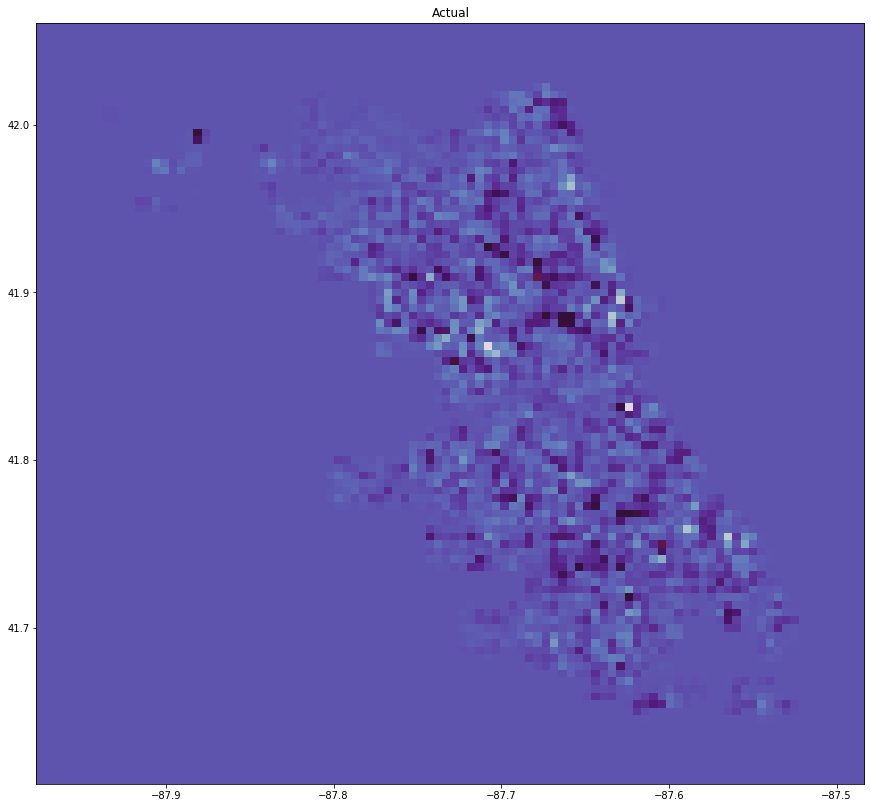

In [55]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.